How to score 0.8134 🏅 in Titanic Kaggle Challenge
The Titanic challenge hosted by Kaggle is a competition in which the goal is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

I have been playing with the Titanic dataset for a while, and I have recently achieved an accuracy score of 0.8134 on the public leaderboard. As I'm writing this post, I am ranked among the top 4% of all Kagglers.
    PHOTO Kaggle
This post is the opportunity to share my solution with you.

To make this tutorial more "academic" so that anyone could benefit, I will first start with an exploratory data analysis (EDA) then I'll follow with feature engineering and finally present the predictive model I set up.

Throughout this jupyter notebook, I will be using Python at each level of the pipeline. The main libraries involved in this tutorial are:

Pandas for data manipulation and ingestion
Matplotlib and seaborn for data visualization
Numpy for multidimensional array computing
sklearn for machine learning and predictive modeling

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

We import the useful libraries.

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

Two datasets are available: a training set and a test set. We'll be using the training set to build our predictive model and the testing set to score it and generate an output file to submit on the Kaggle evaluation system.

We'll see how this procedure is done at the end of this post.

Now let's start by loading the training set.
Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

In [3]:
data = pd.read_csv('./data/train.csv')
print(data.shape)
#(8693, 14)

(8693, 14)


8693 rows, 14 columns

Pandas allows you to have a sneak peak at your data.

In [4]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The Transported column is the target variable. If Transported = True the passenger was transported to another dimension, otherwise he's not. The is the variable we're going to predict.

The other variables describe the passengers. They are the features.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


The cabin column contains htree informations. Let's split it up

In [5]:
data[['deck', 'num', 'side']] = data.Cabin.str.split("/", expand = True)

In [6]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S



Pandas allows you to a have a high-level simple statistical description of the numerical features. This can be done using the describe method.

In [7]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The count variable shows that all columns except Age have missing values.

One solution is to fill in the null values with the median. We could also impute with the mean age but the median is more robust to outliers.

In [8]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [9]:
data['RoomService'] = data['RoomService'].fillna(data['RoomService'].median())
data['FoodCourt'] = data['FoodCourt'].fillna(data['FoodCourt'].median())
data['ShoppingMall'] = data['ShoppingMall'].fillna(data['ShoppingMall'].median())
data['Spa'] = data['Spa'].fillna(data['Spa'].median())
data['VRDeck'] = data['VRDeck'].fillna(data['VRDeck'].median())

Let's now make some charts.

Let's visualize transport based on the homeplanet.

<AxesSubplot: xlabel='VIP'>

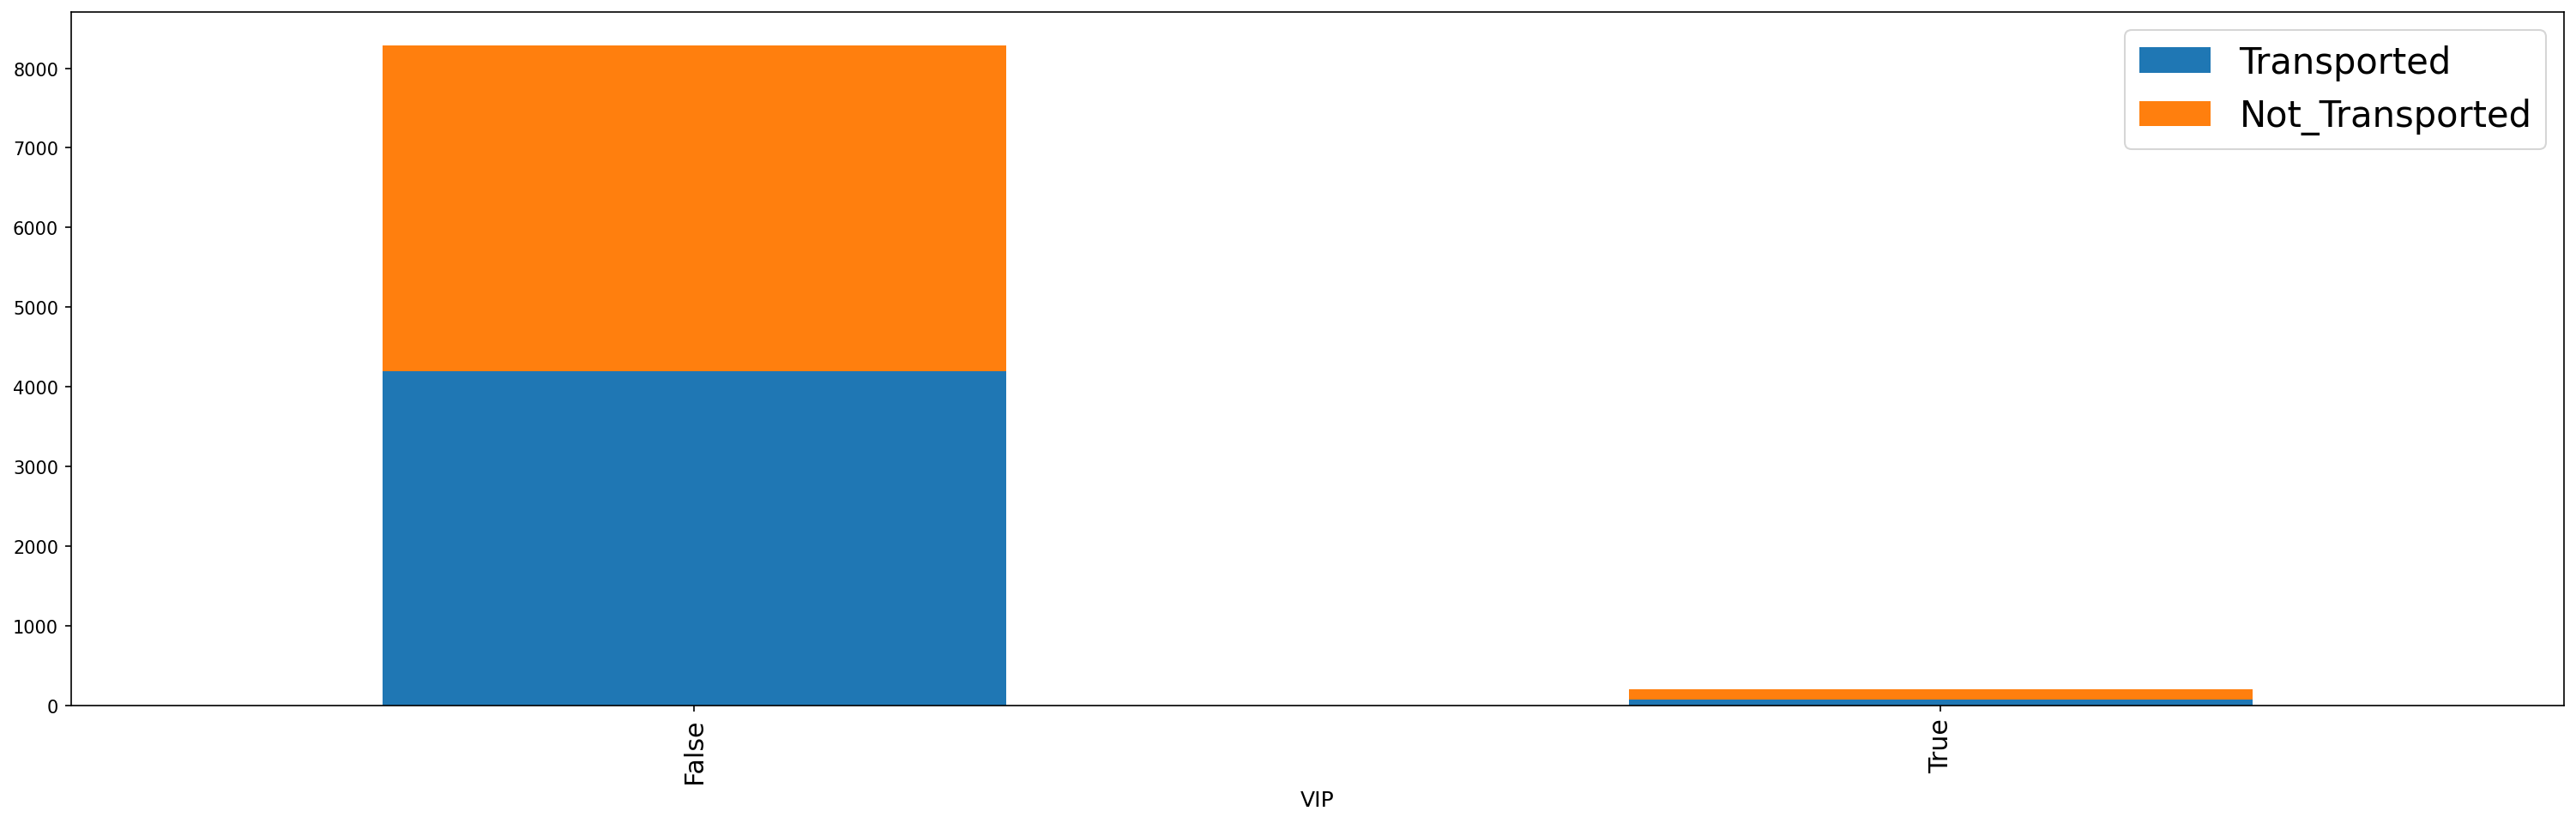

In [10]:
data['Not_Transported'] = 1 - data['Transported']
data.groupby('VIP').agg('sum')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7),stacked=True,)# colors=['g', 'r']);

It looks like there are very few VIP passengers and the status has no effect on transport. But let's see the ratio.

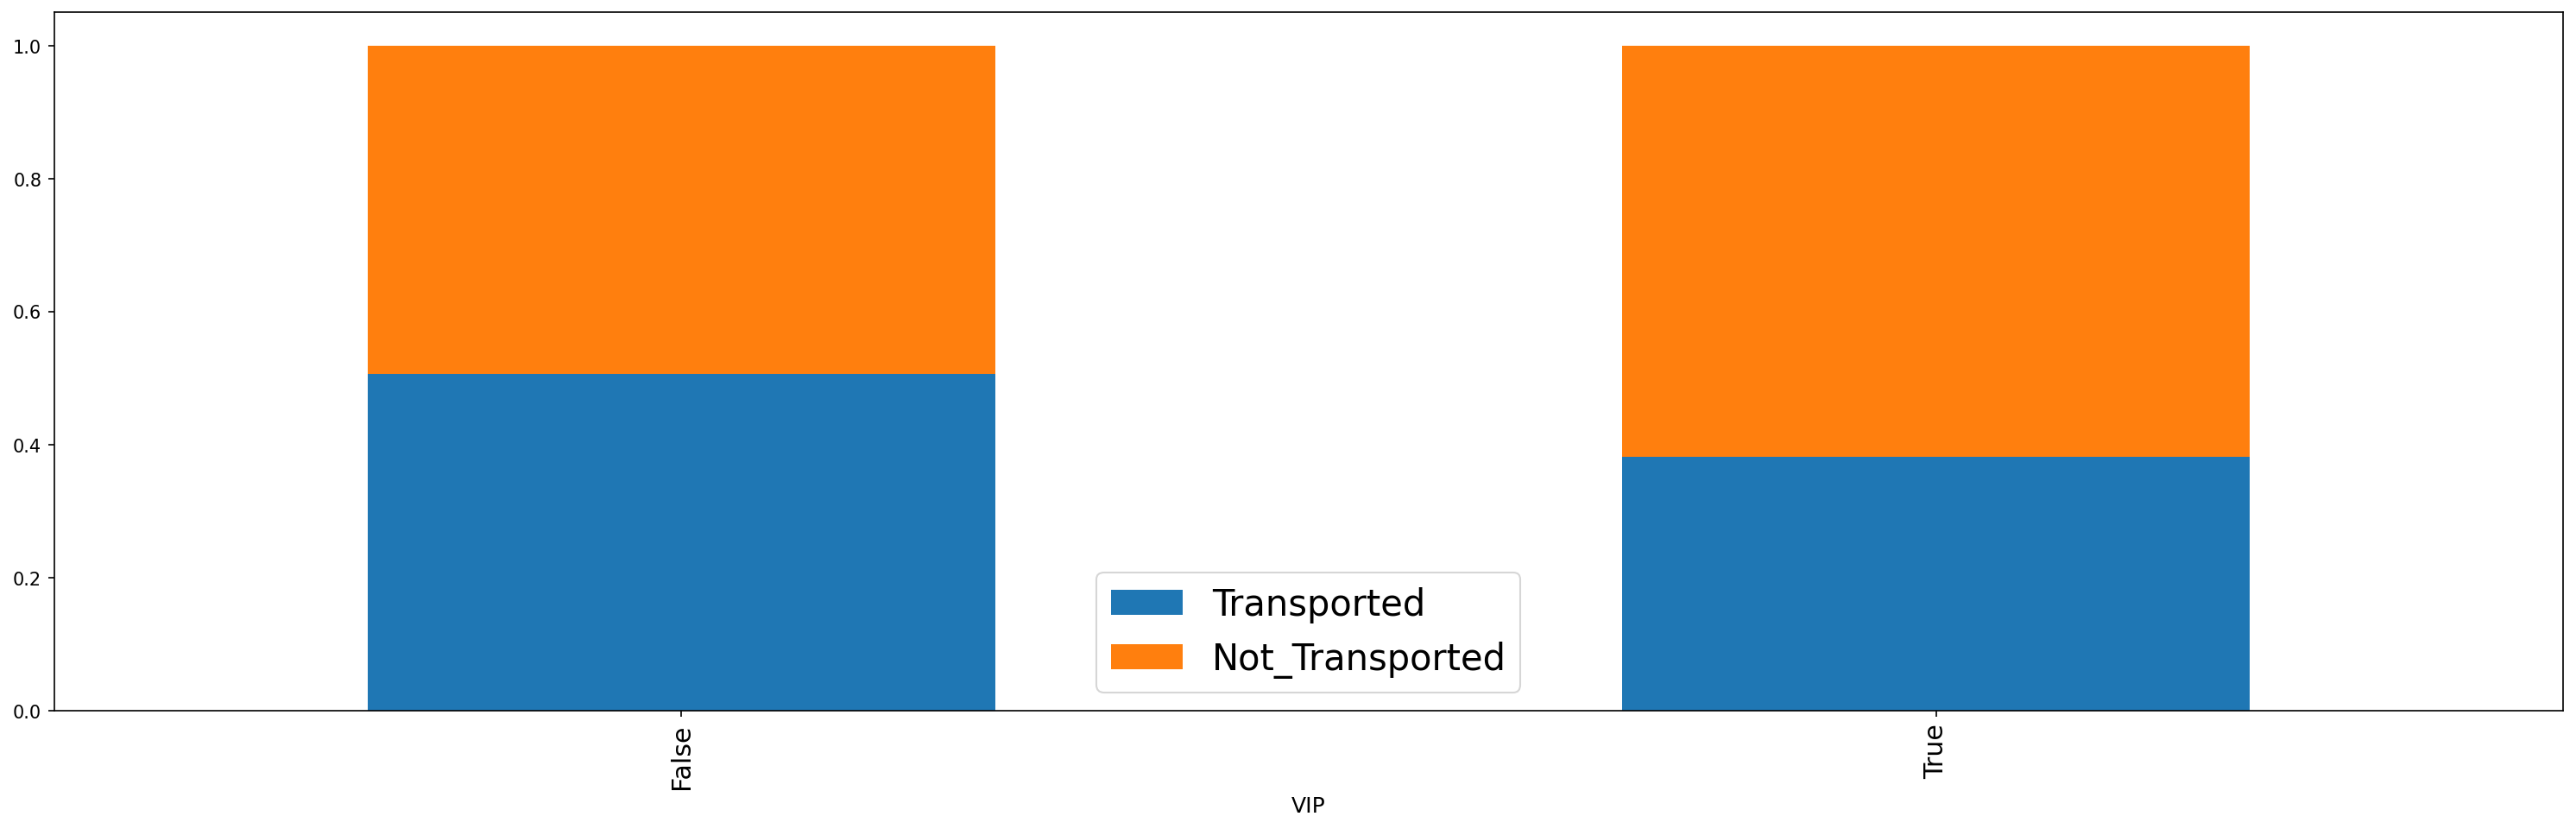

In [11]:
data.groupby('VIP').agg('mean')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7), stacked=True);

Ok, actually VIPs have a slightly hierer chance not to be transported.
What about cryo sleep?

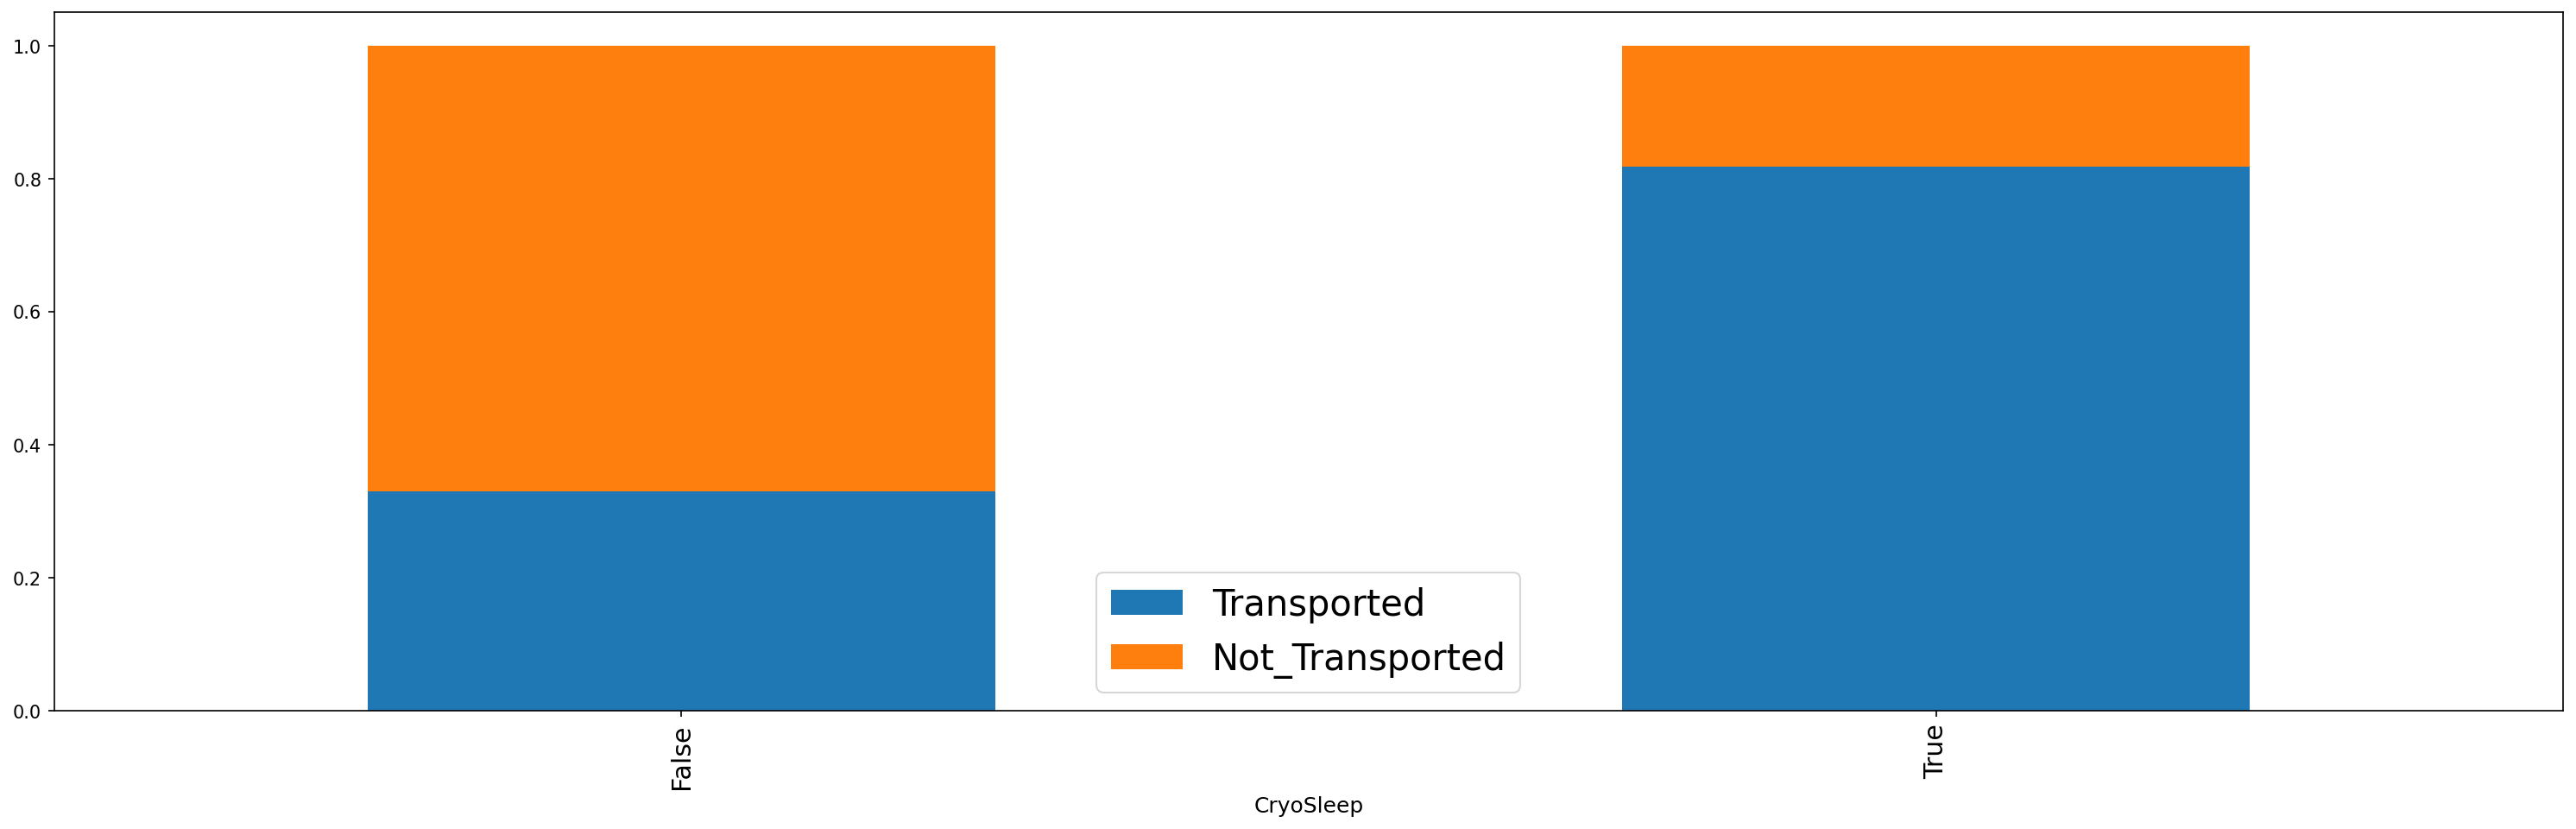

In [12]:
data.groupby('CryoSleep').agg('mean')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7), stacked=True);

Wow, people in CryoSleep have a high chance to be transported. Now let's see how this coreallates with age.

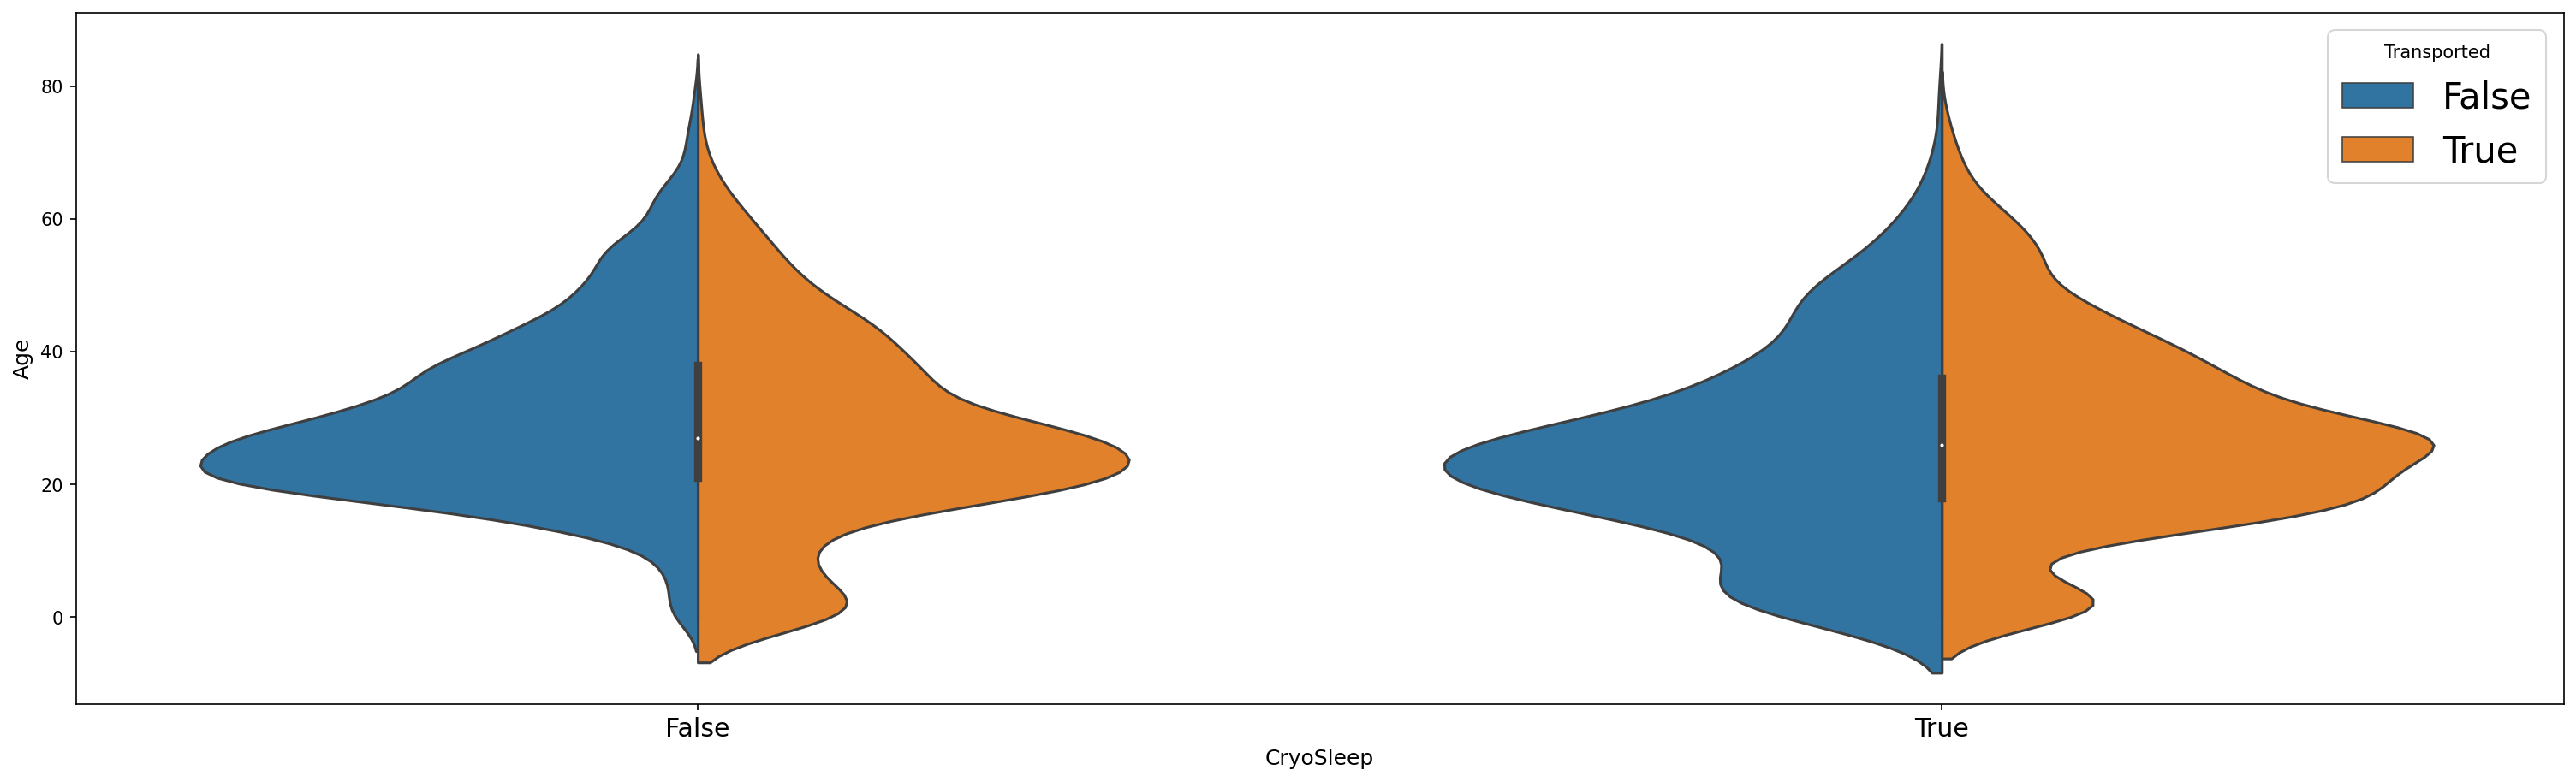

In [13]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='CryoSleep', y='Age', 
               hue='Transported', data=data, 
               split=True
              );

It looks like people who aren't in cryp sleep tend to be transported if they are younger than about 15yo. A lot of people at age between 20 and 40 are not transported.
So if you are young or in cryo sleep there's a high chance to be transported.
Let's check the HomePlanet.

<AxesSubplot: xlabel='HomePlanet'>

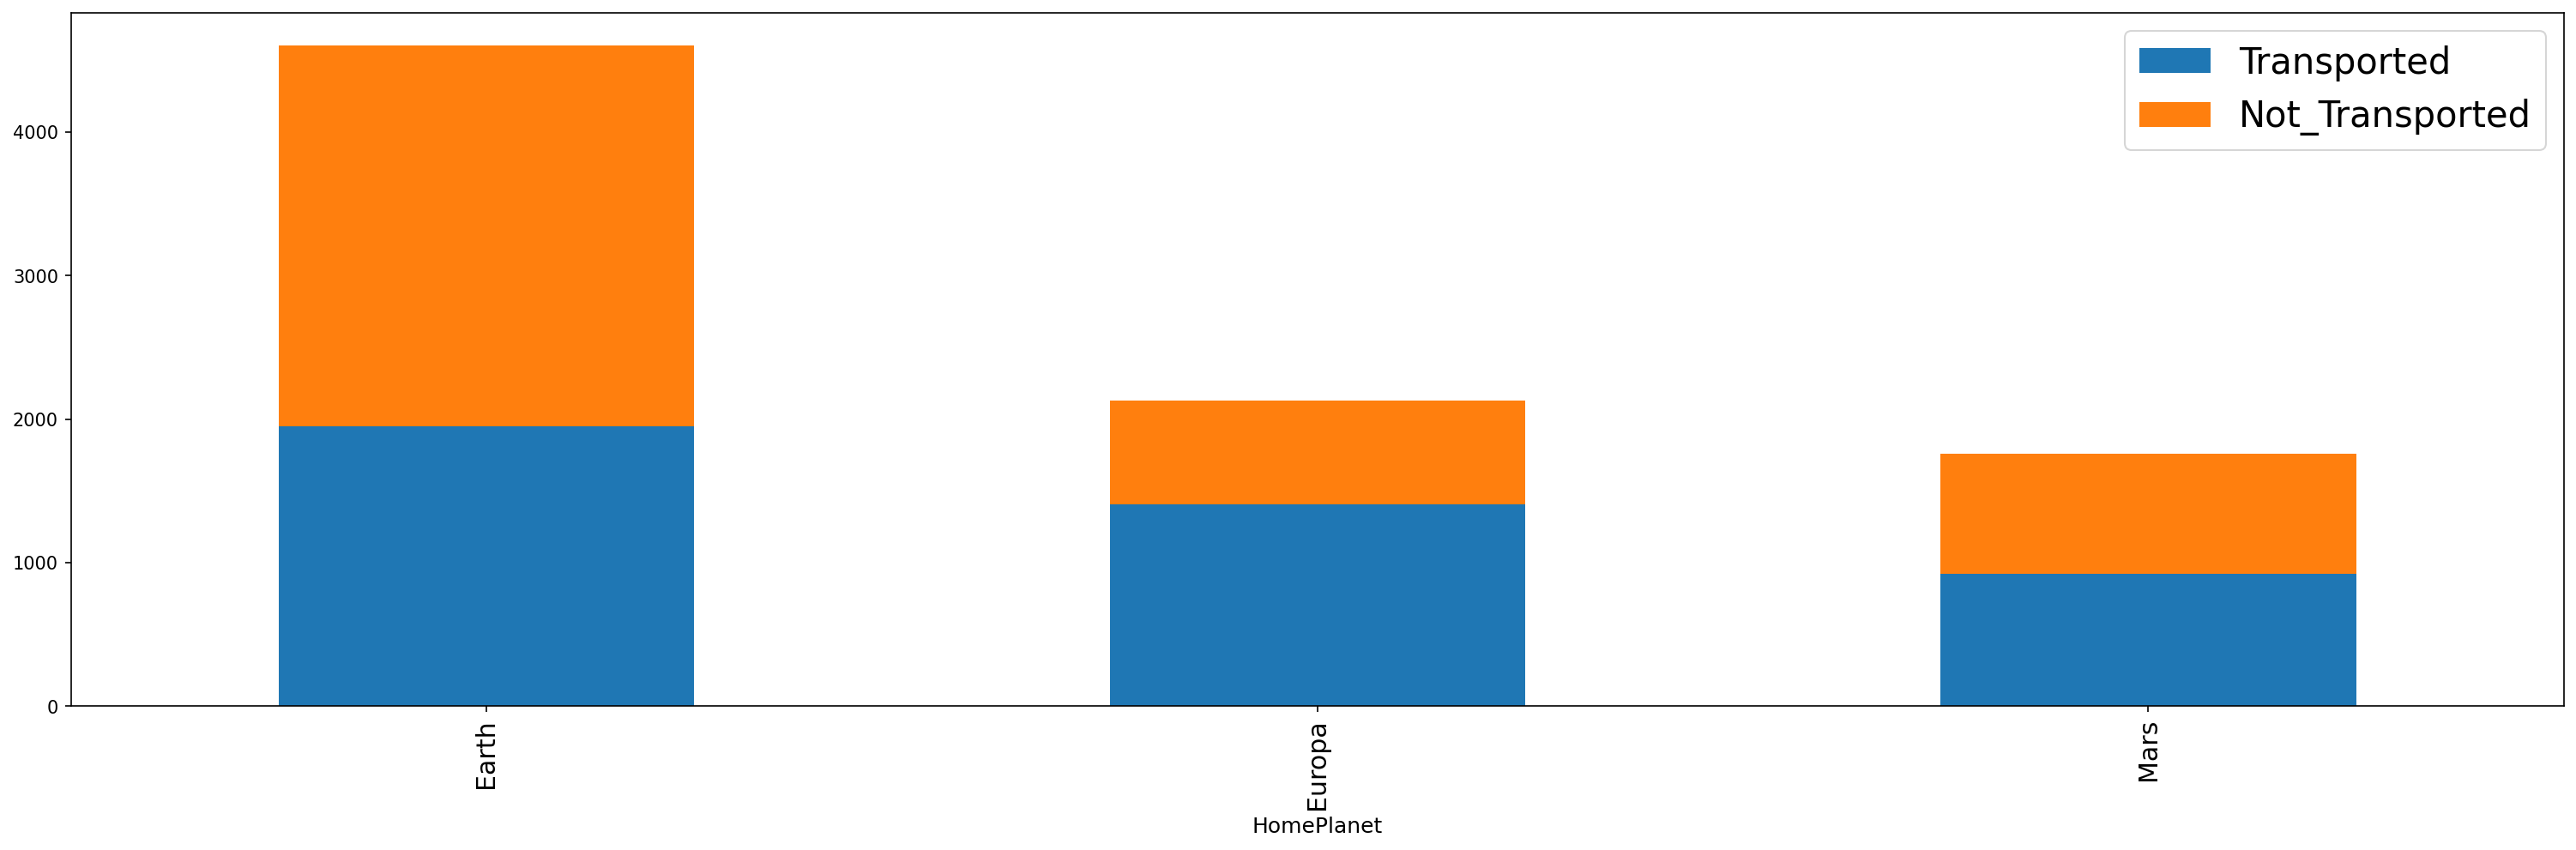

In [14]:
data['Not_Transported'] = 1 - data['Transported']
data.groupby('HomePlanet').agg('sum')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7),stacked=True,)

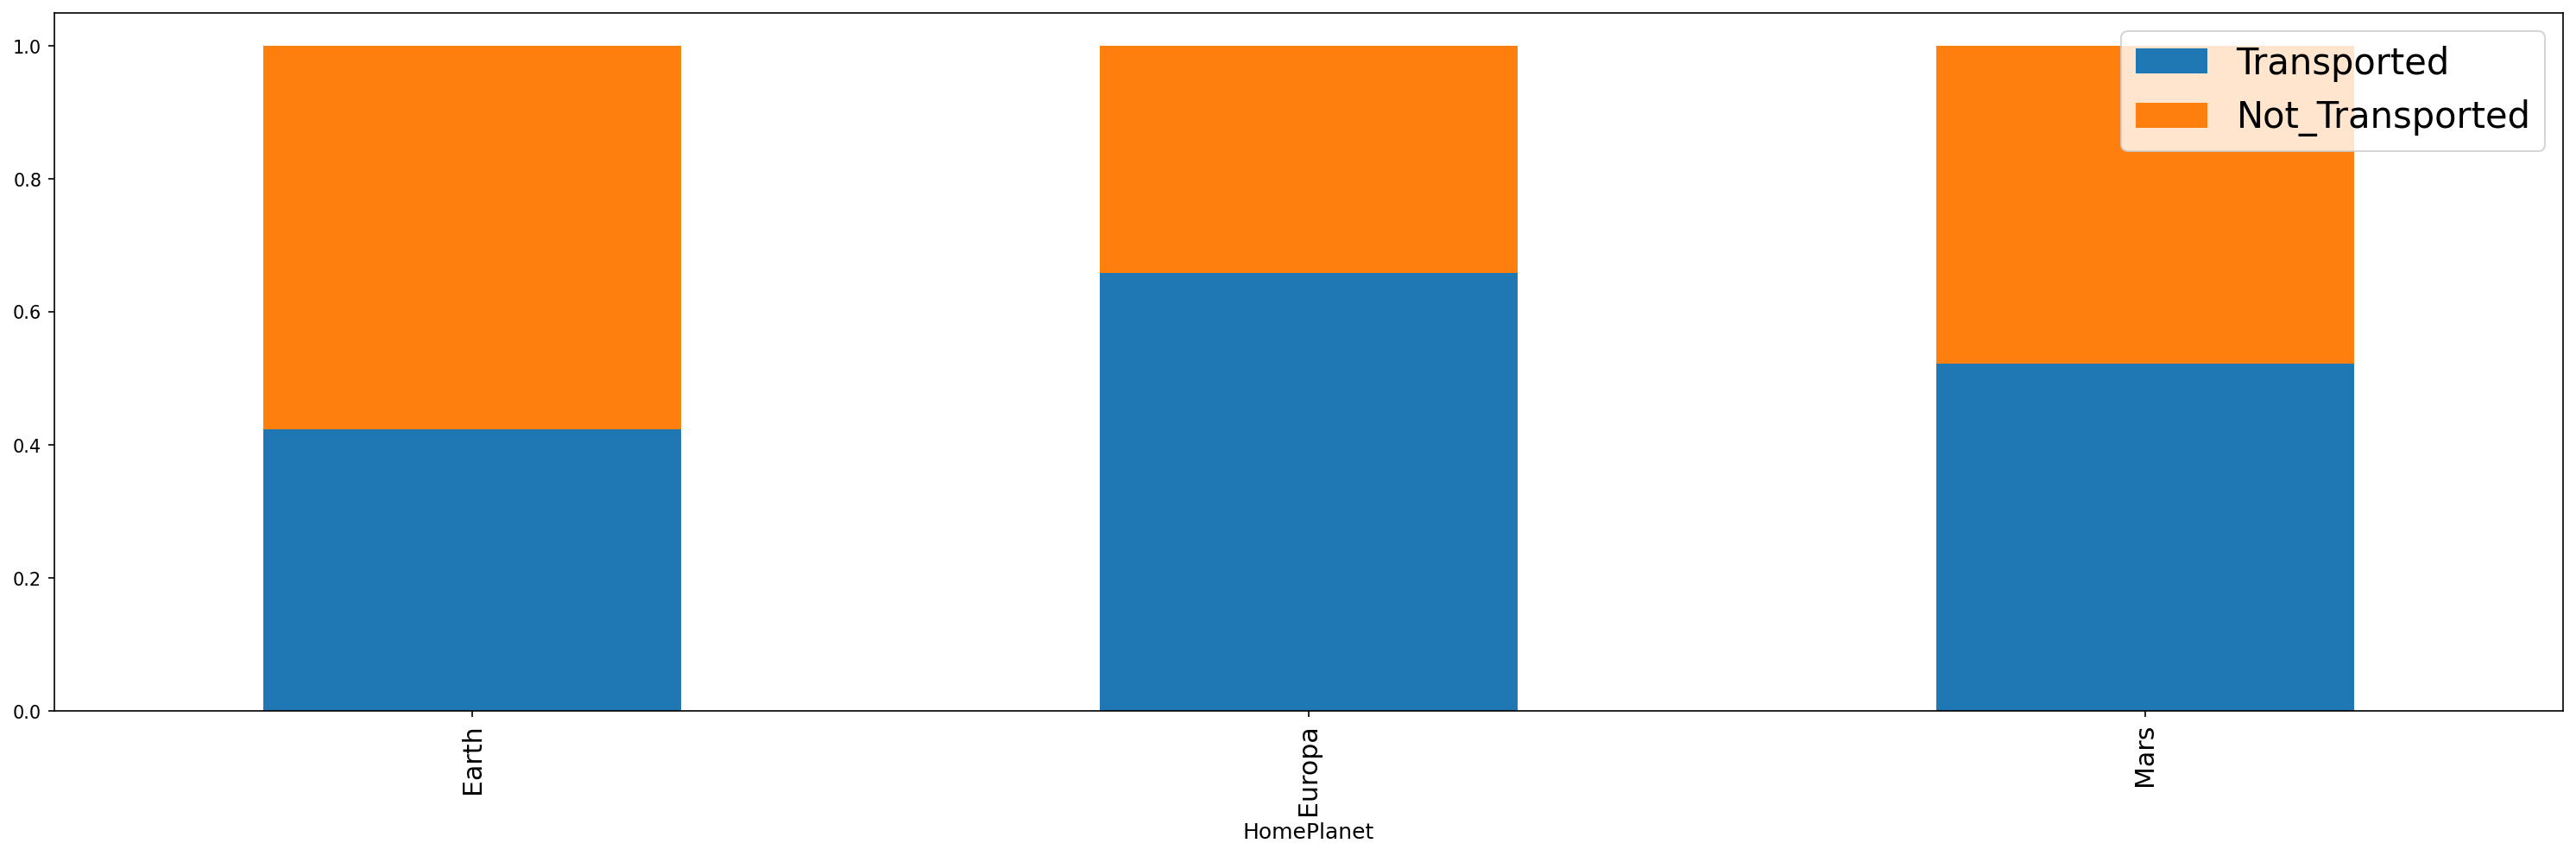

In [15]:
data.groupby('HomePlanet').agg('mean')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7), stacked=True);

While origin Mars seems to have no effect, Europa citizens are more likely transported than Earthlings.
And how about the destination?

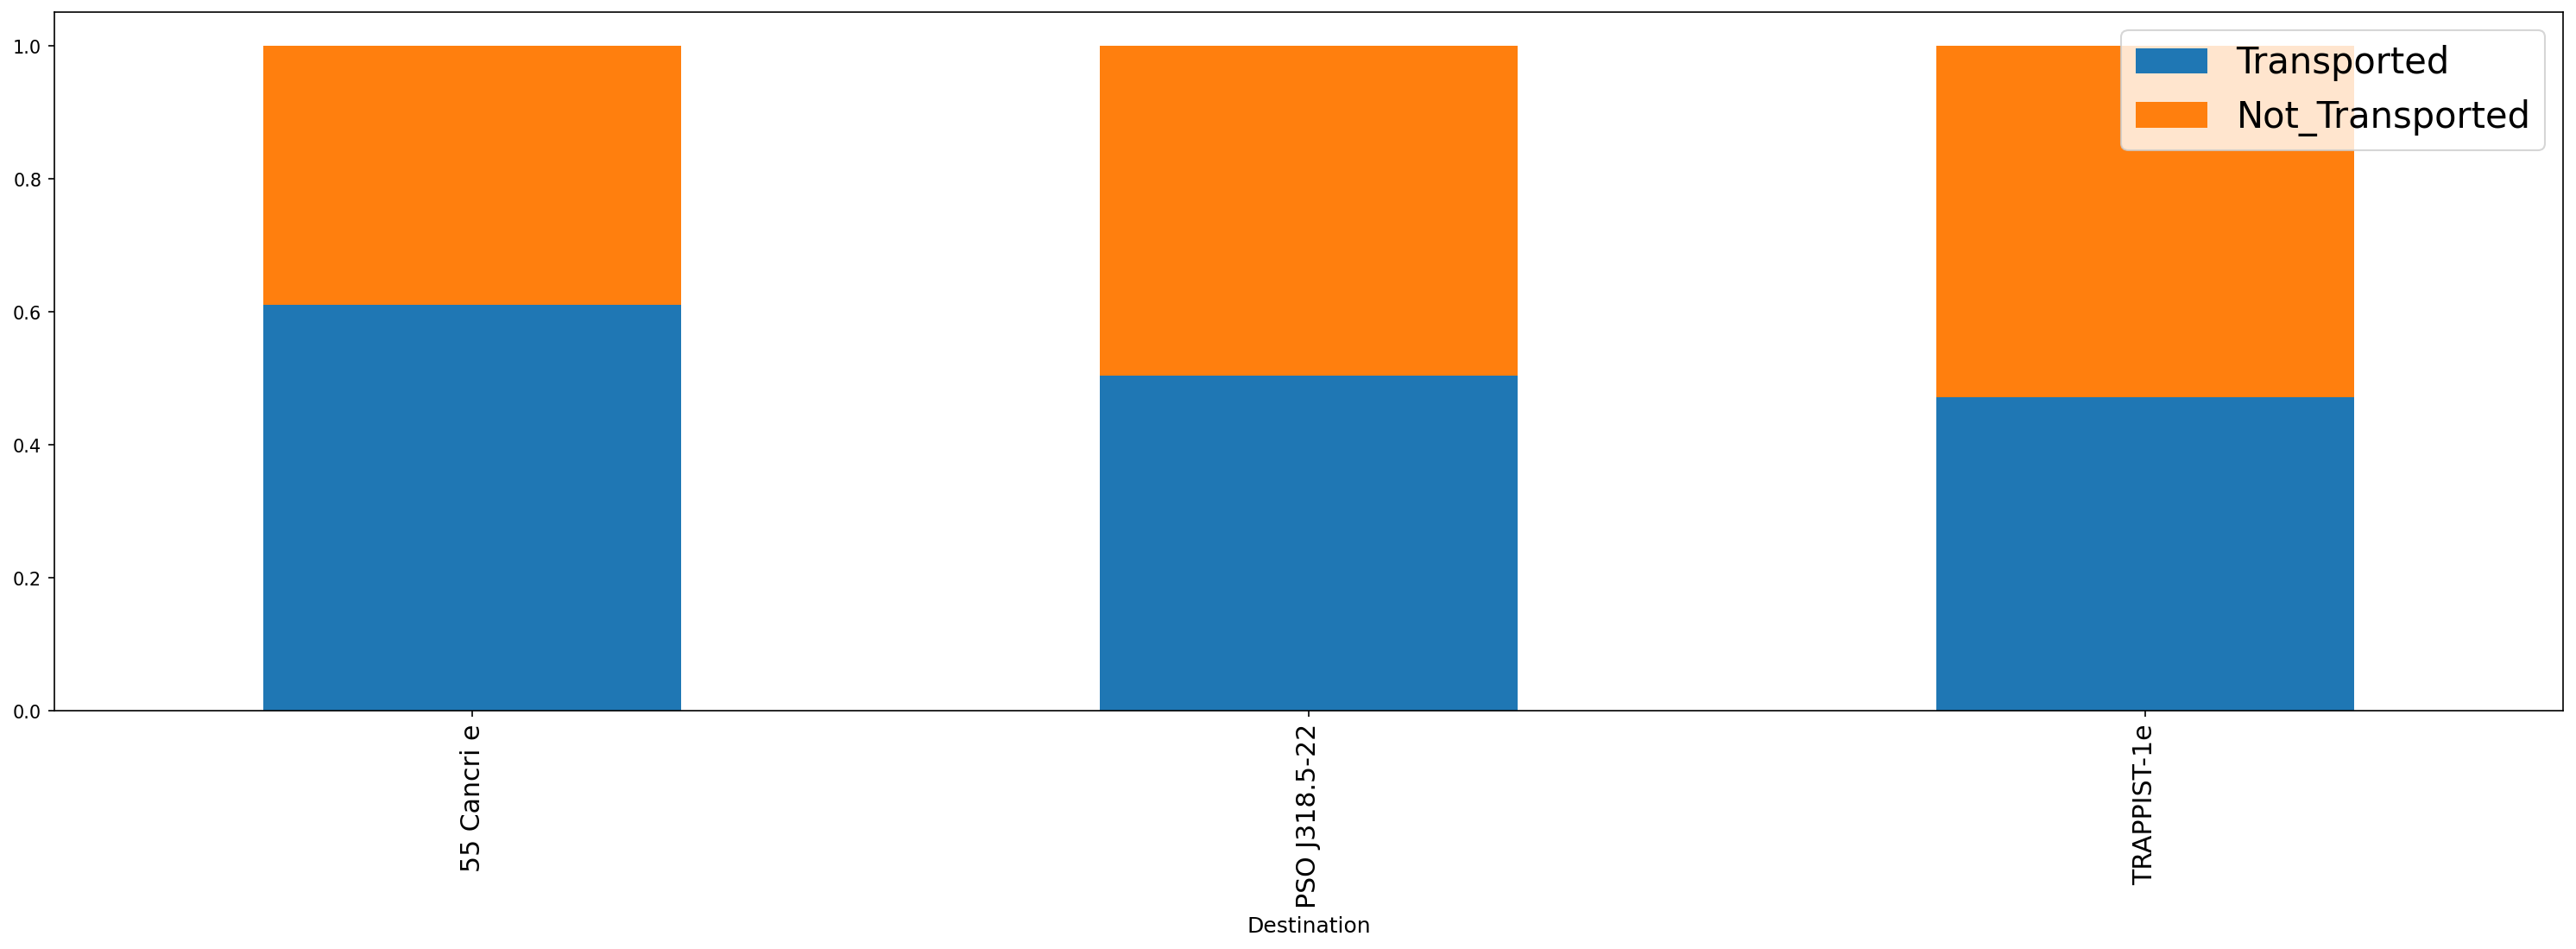

In [16]:
data.groupby('Destination').agg('mean')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7), stacked=True);

Destination 55 Cancri seams to have a little impact on transportation.

Now we check if the spending has any effect.

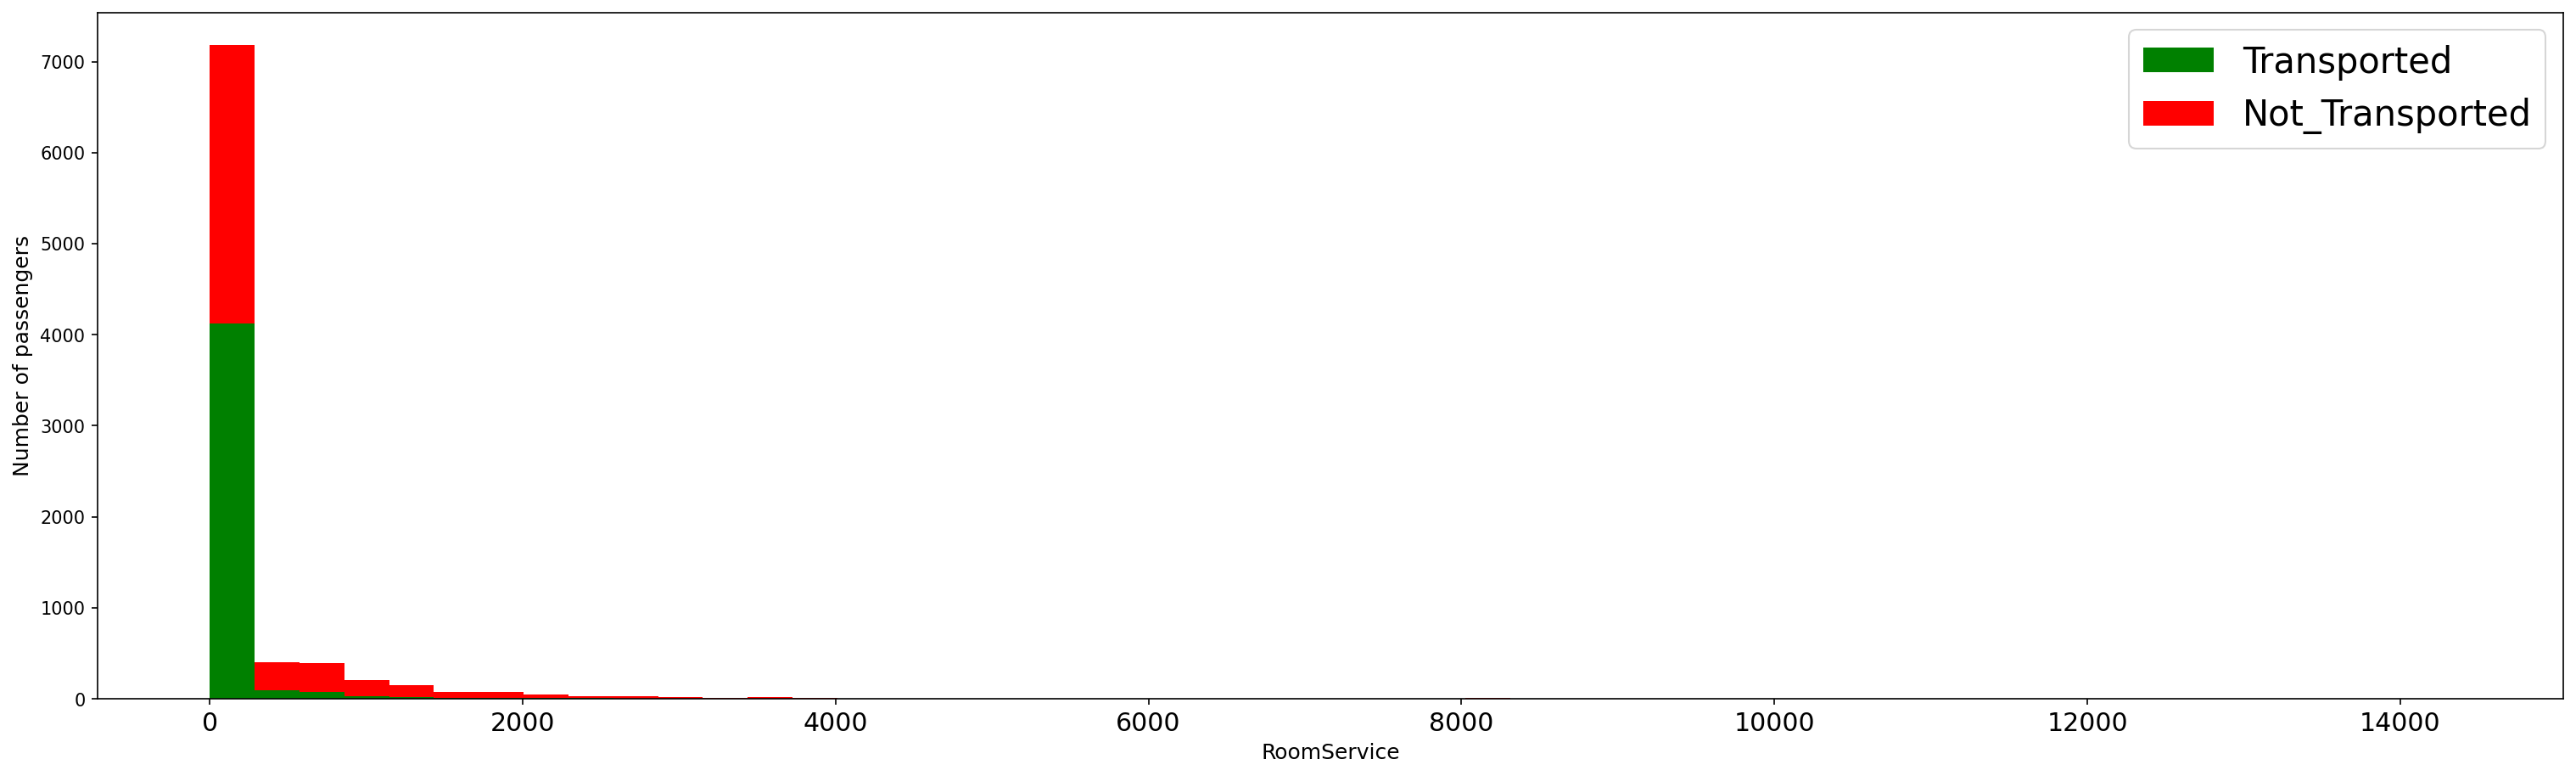

In [17]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Transported'] == 1]['RoomService'], data[data['Transported'] == 0]['RoomService']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Transported','Not_Transported'])
plt.xlabel('RoomService')
plt.ylabel('Number of passengers')
plt.legend();

If people spend money on RoomService they are less likely transported.

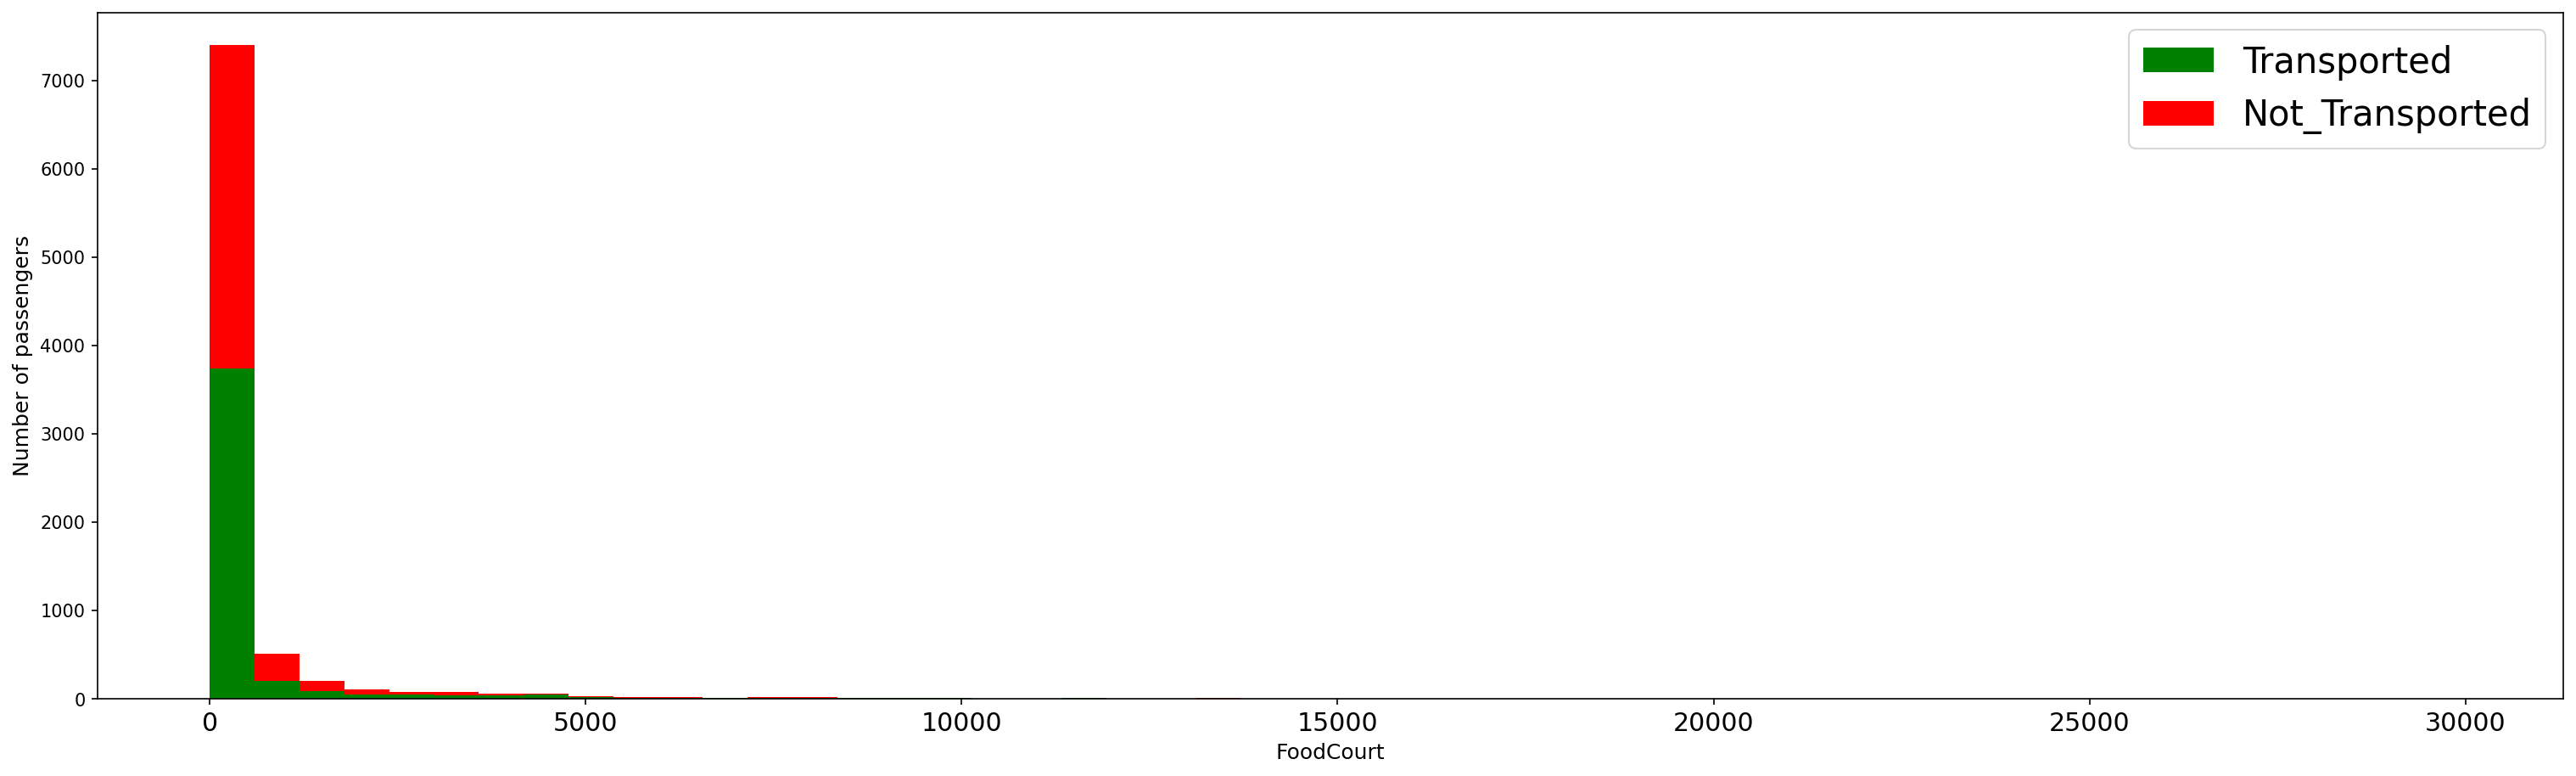

In [18]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Transported'] == 1]['FoodCourt'], data[data['Transported'] == 0]['FoodCourt']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Transported','Not_Transported'])
plt.xlabel('FoodCourt')
plt.ylabel('Number of passengers')
plt.legend();

FoodCourt doen't have a clear impact.

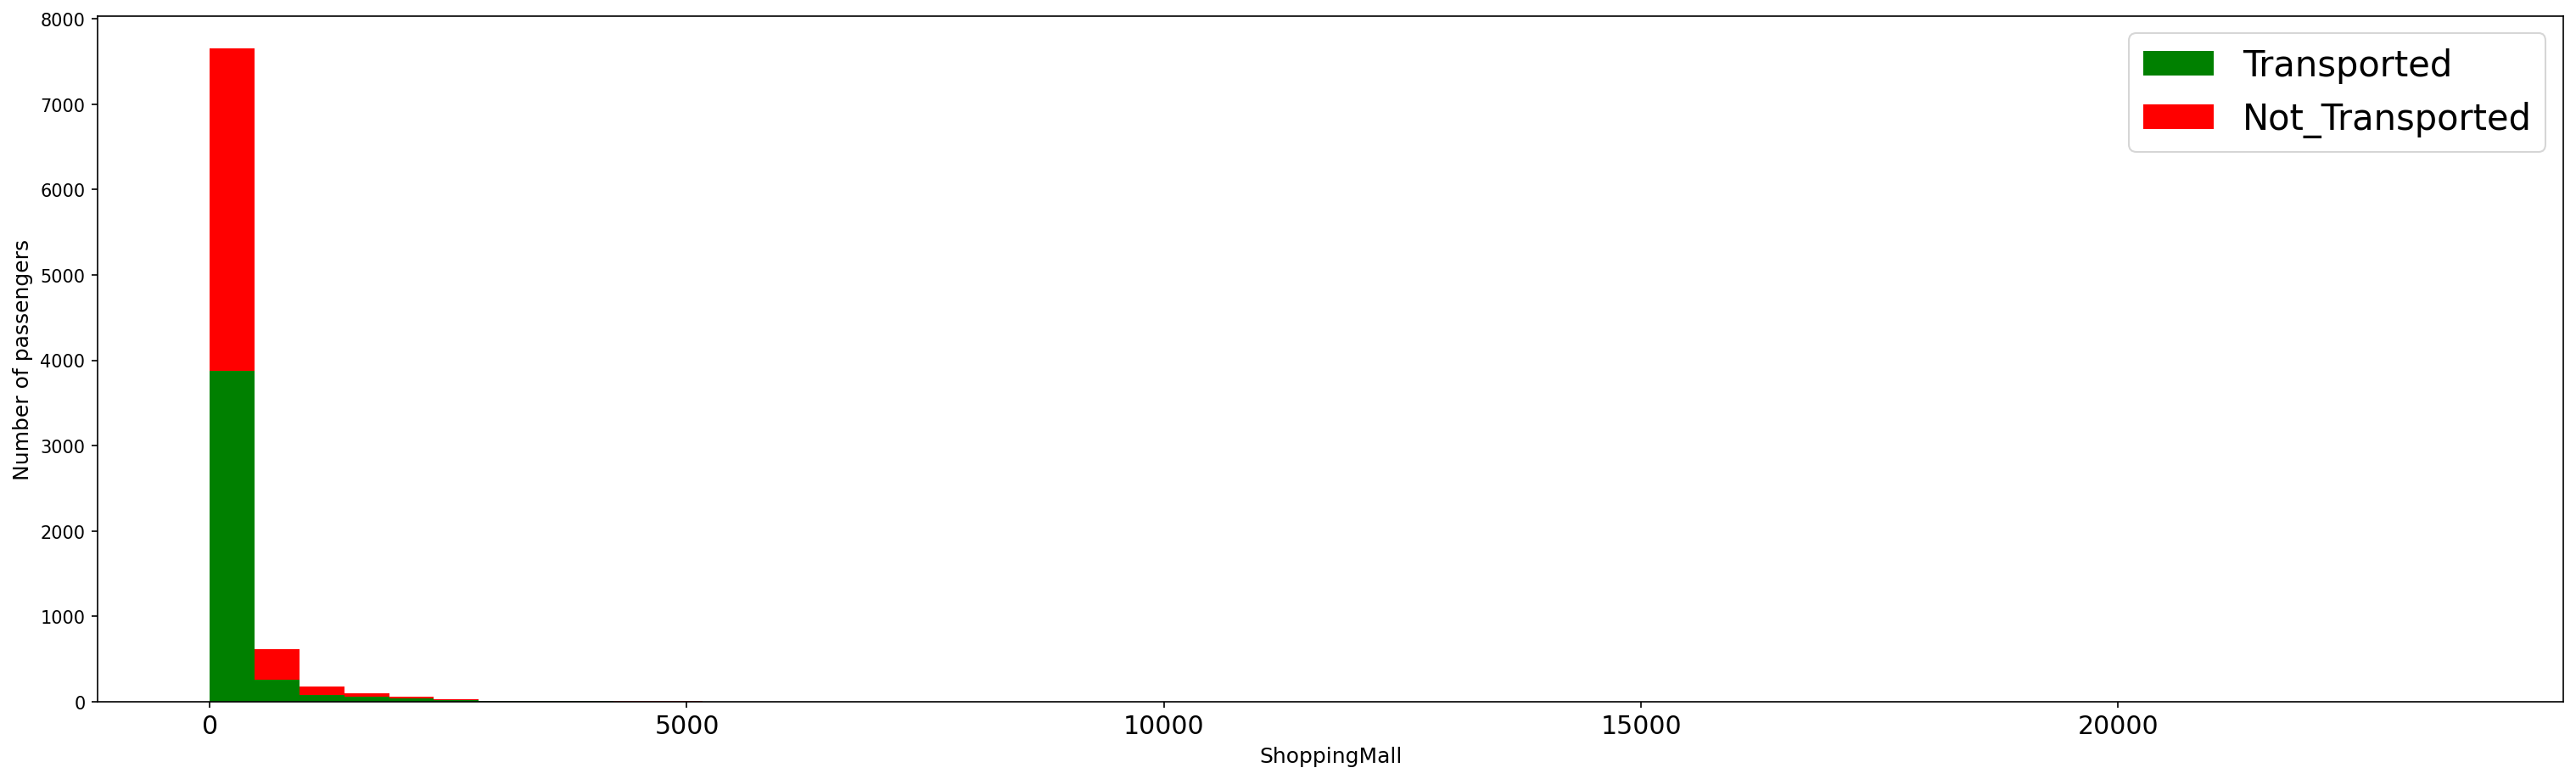

In [19]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Transported'] == 1]['ShoppingMall'], data[data['Transported'] == 0]['ShoppingMall']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Transported','Not_Transported'])
plt.xlabel('ShoppingMall')
plt.ylabel('Number of passengers')
plt.legend();

ShoppingMall is also not a very clear indicator.

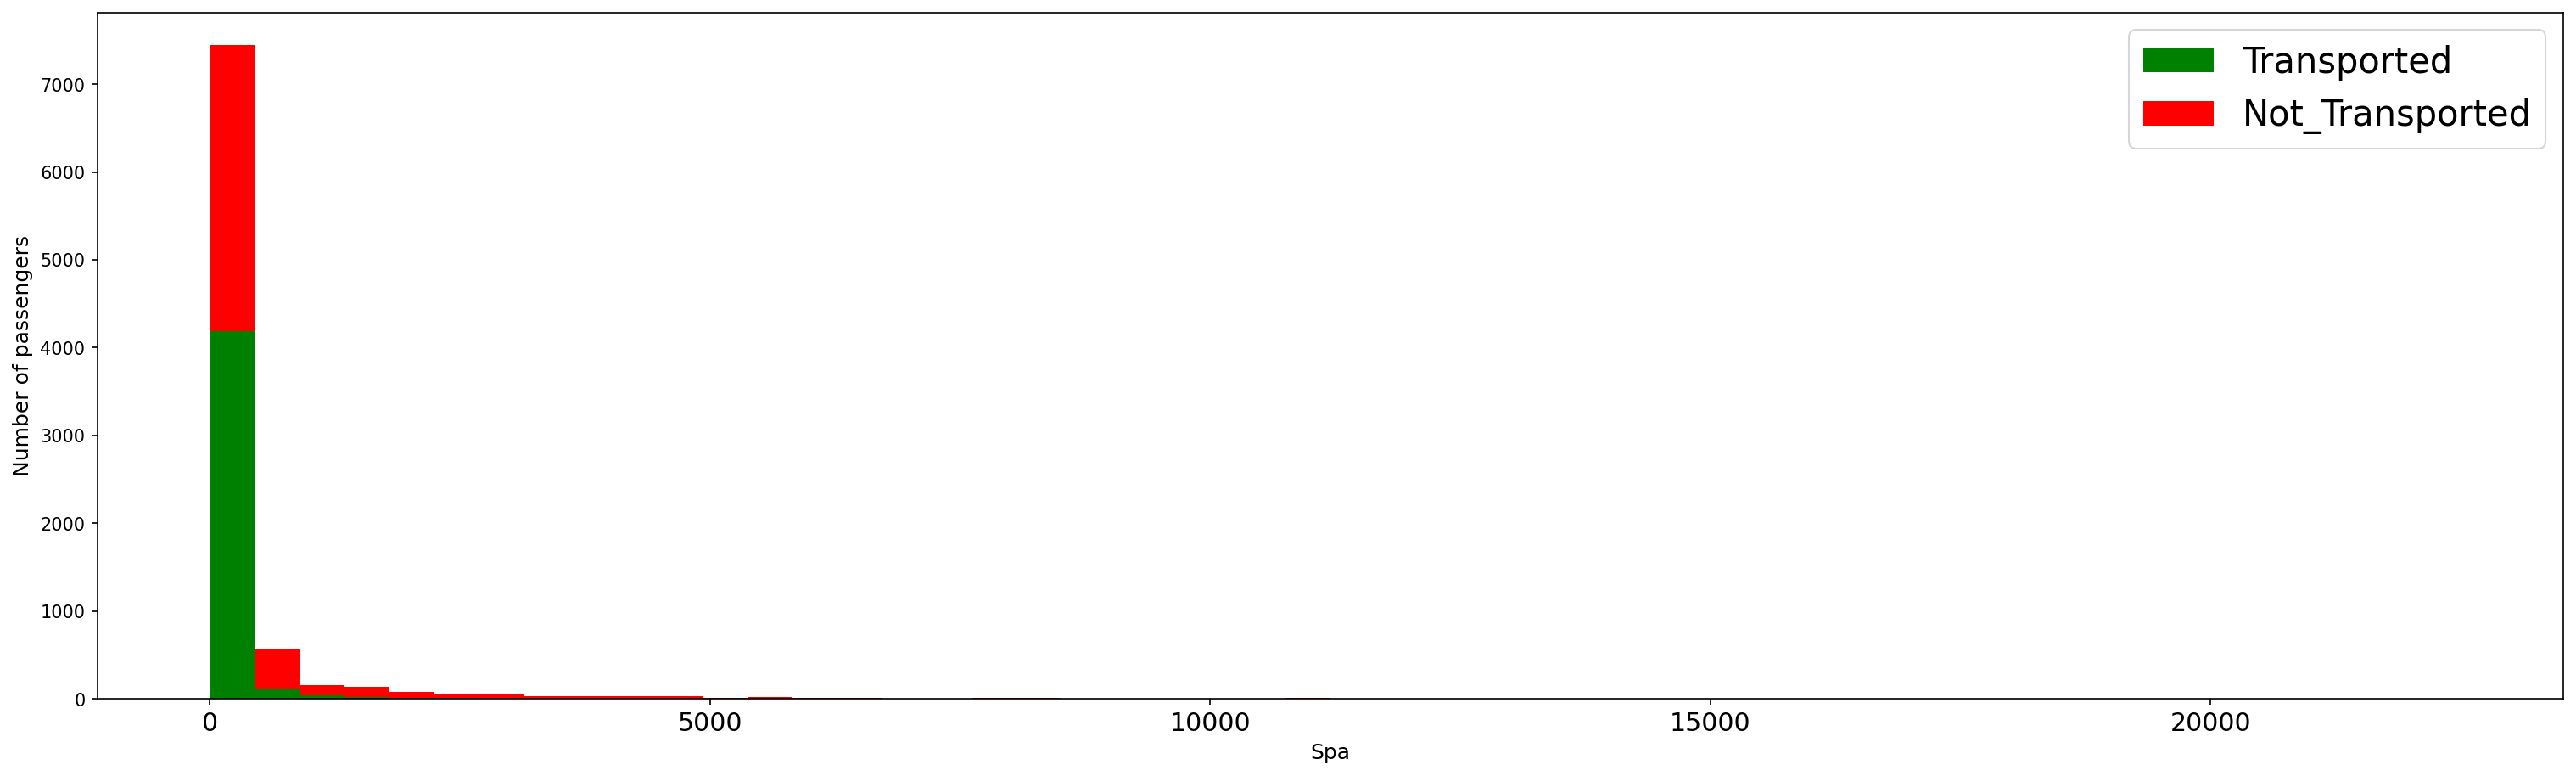

In [20]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Transported'] == 1]['Spa'], data[data['Transported'] == 0]['Spa']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Transported','Not_Transported'])
plt.xlabel('Spa')
plt.ylabel('Number of passengers')
plt.legend();

Just like room service spending money in spa brings less transport chance.

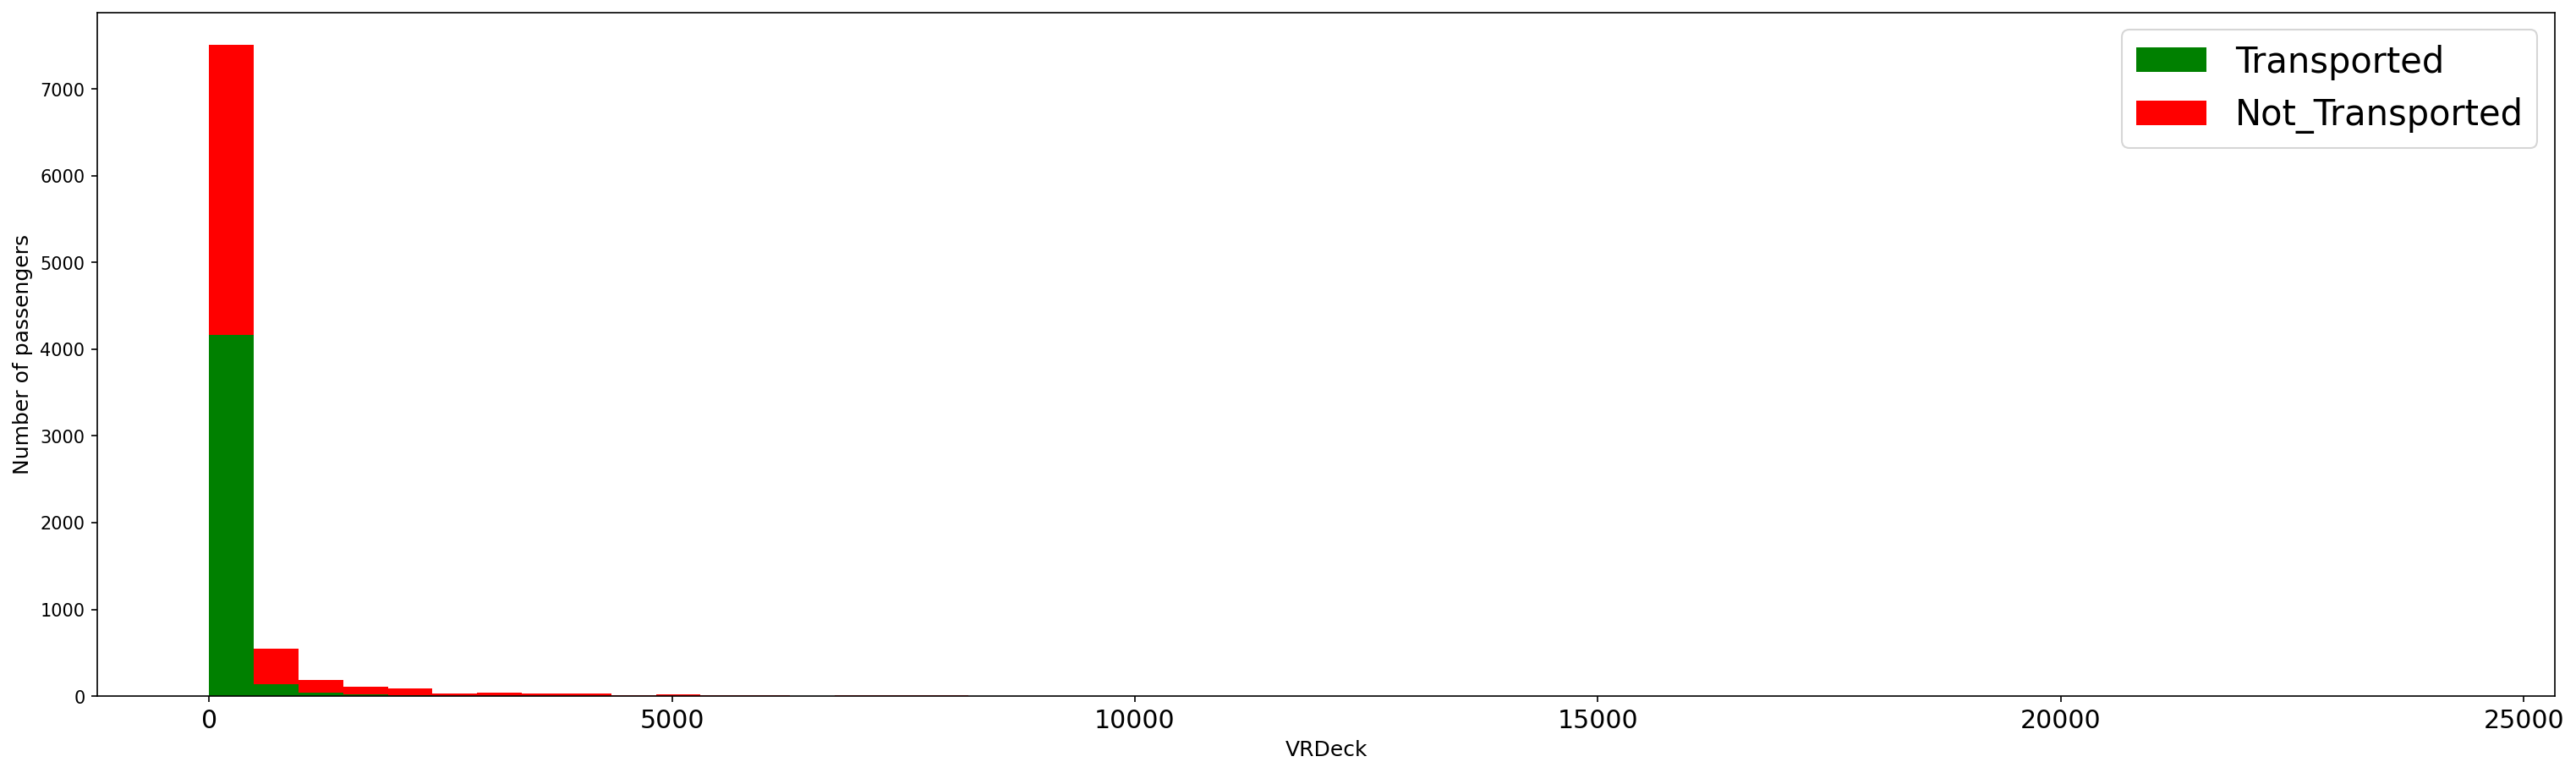

In [21]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Transported'] == 1]['VRDeck'], data[data['Transported'] == 0]['VRDeck']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Transported','Not_Transported'])
plt.xlabel('VRDeck')
plt.ylabel('Number of passengers')
plt.legend();

VRDeck is also bad for transport. But the clearest indicator was room service so let's check the cabins:

<AxesSubplot: xlabel='deck'>

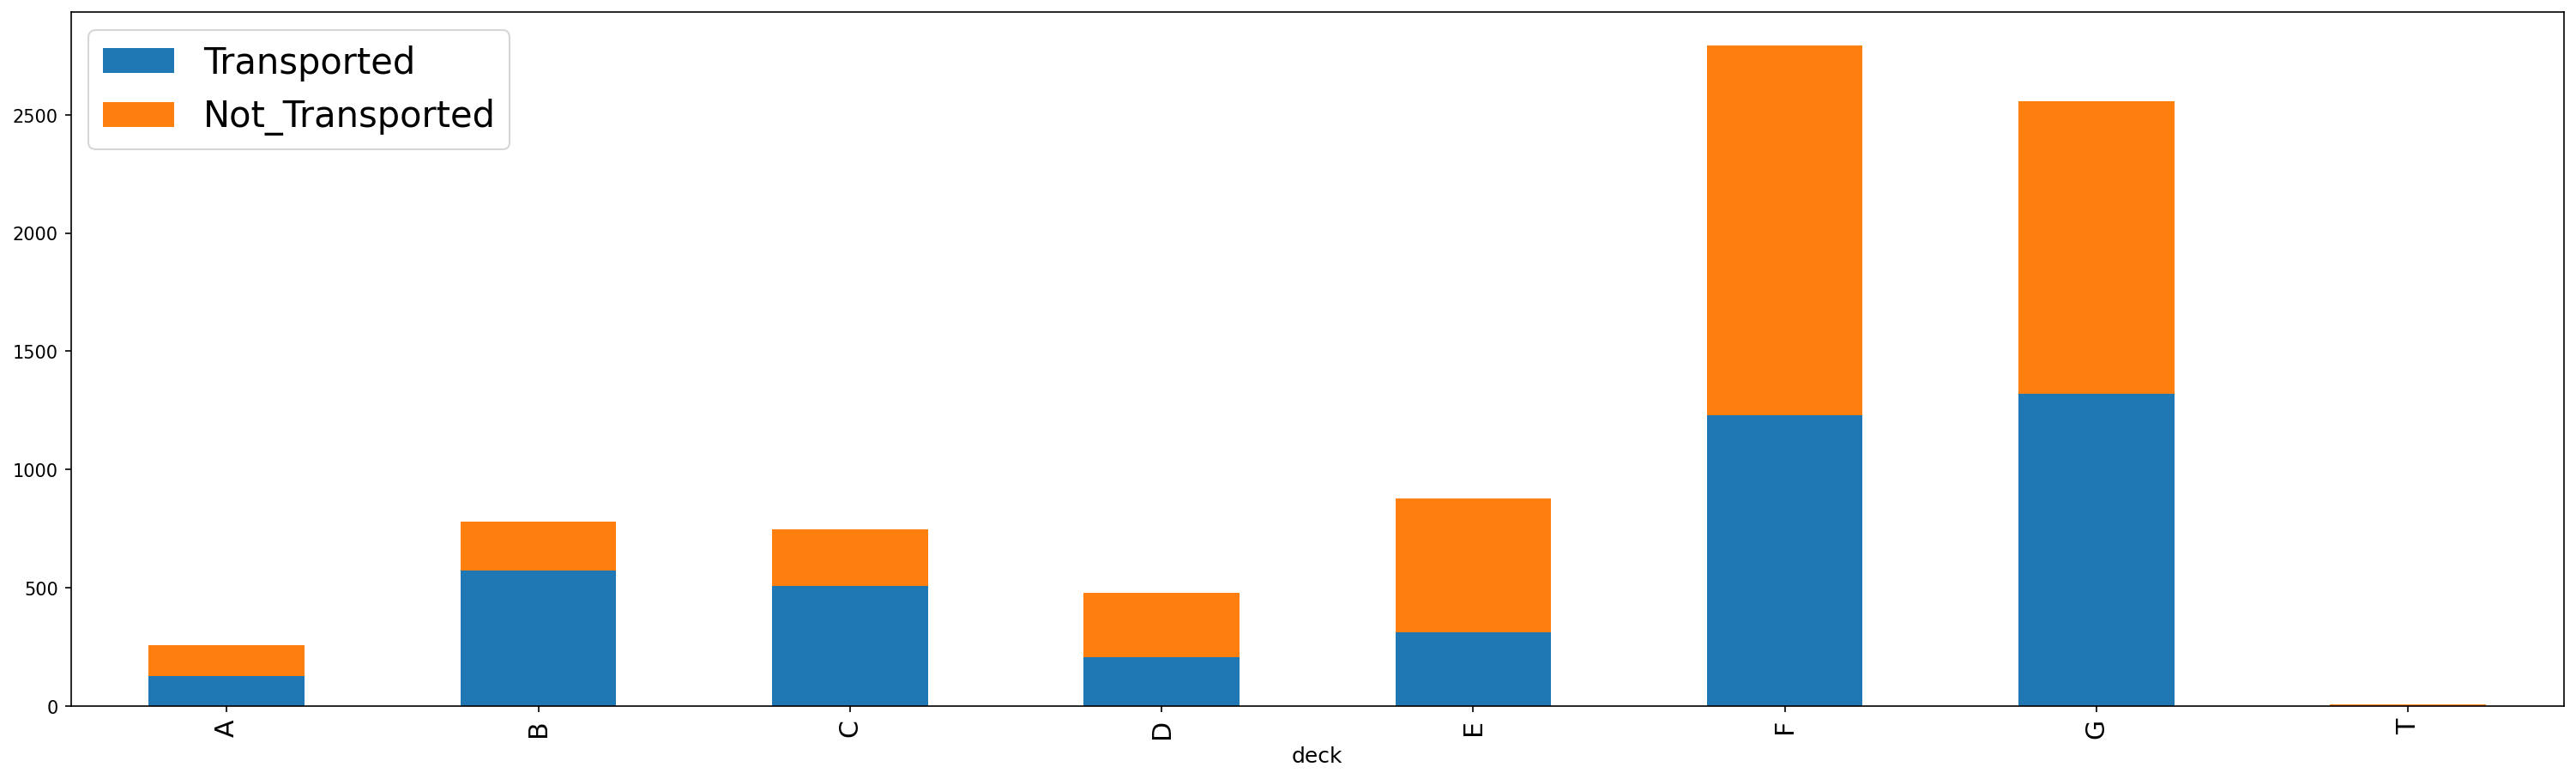

In [22]:
data['Not_Transported'] = 1 - data['Transported']
data.groupby('deck').agg('sum')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7),stacked=True,)

<AxesSubplot: xlabel='side'>

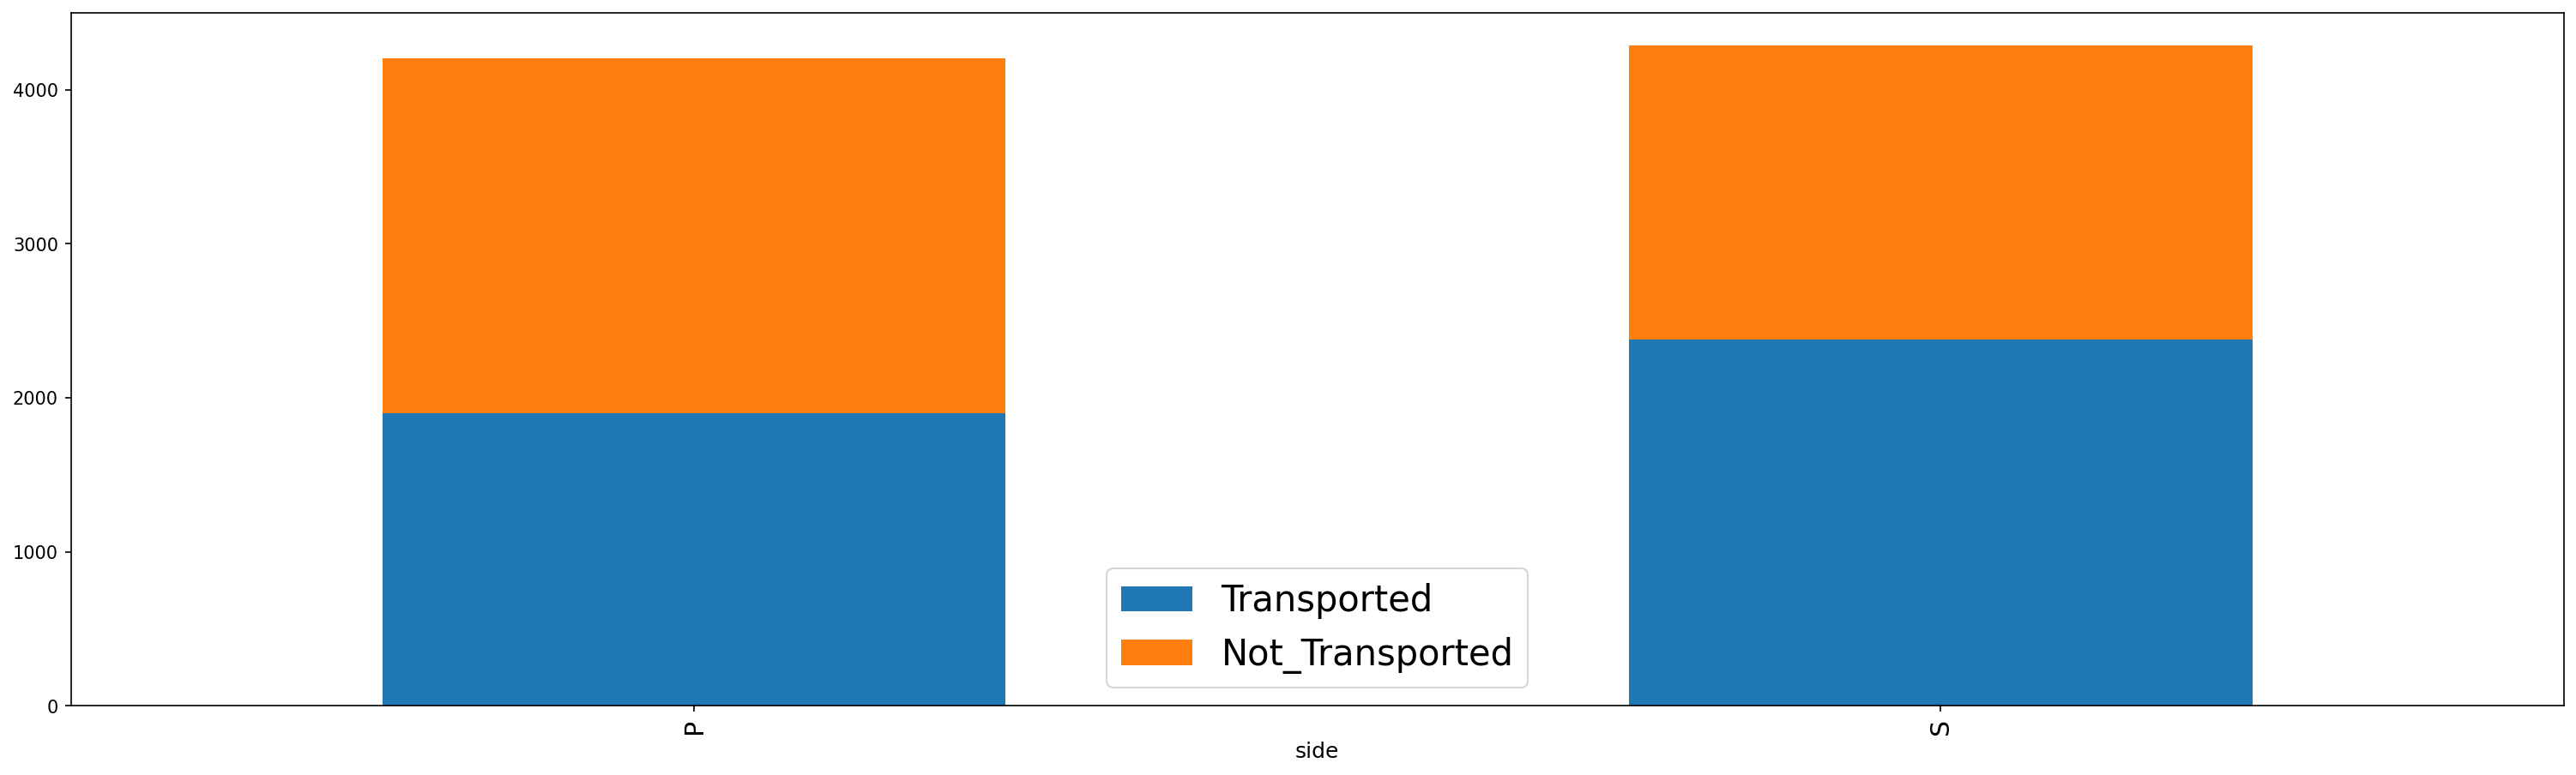

In [23]:
data['Not_Transported'] = 1 - data['Transported']
data.groupby('side').agg('sum')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7),stacked=True,)

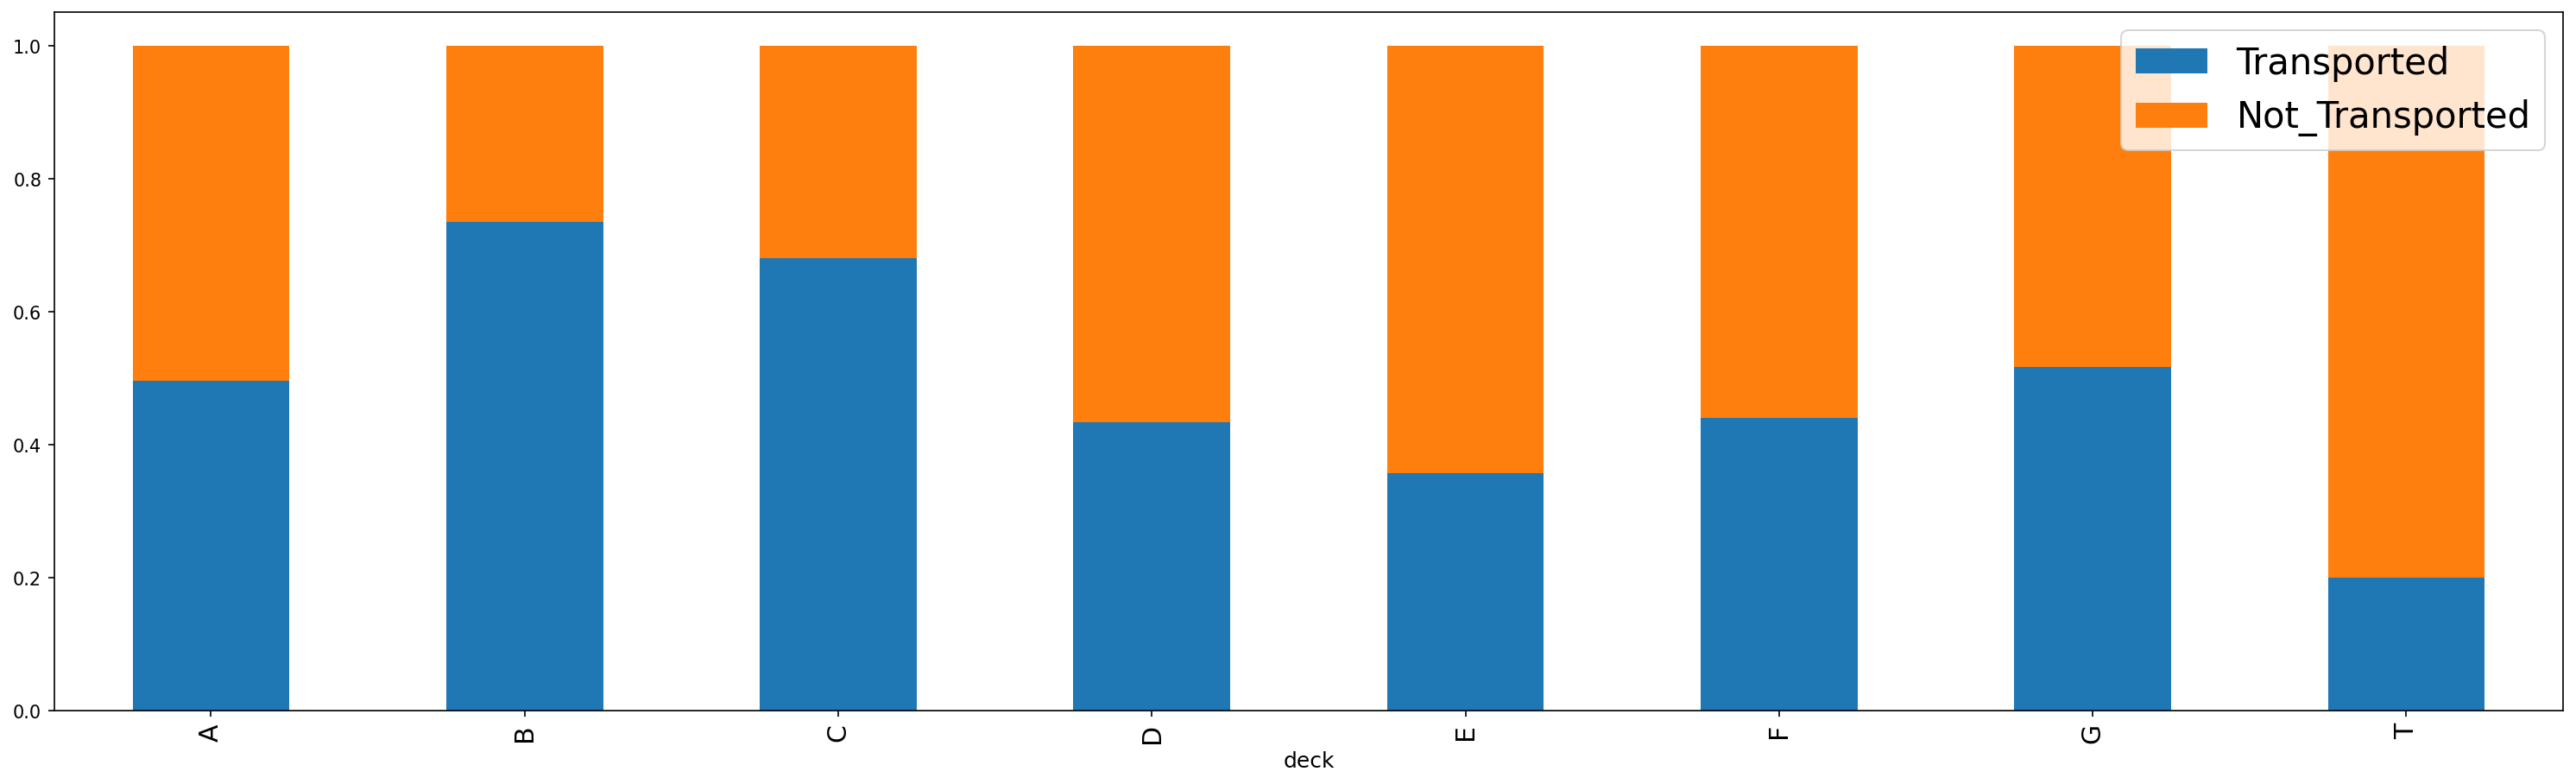

In [24]:
data.groupby('deck').agg('mean')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7), stacked=True);

Decks seems to matter sometimes. And sides?

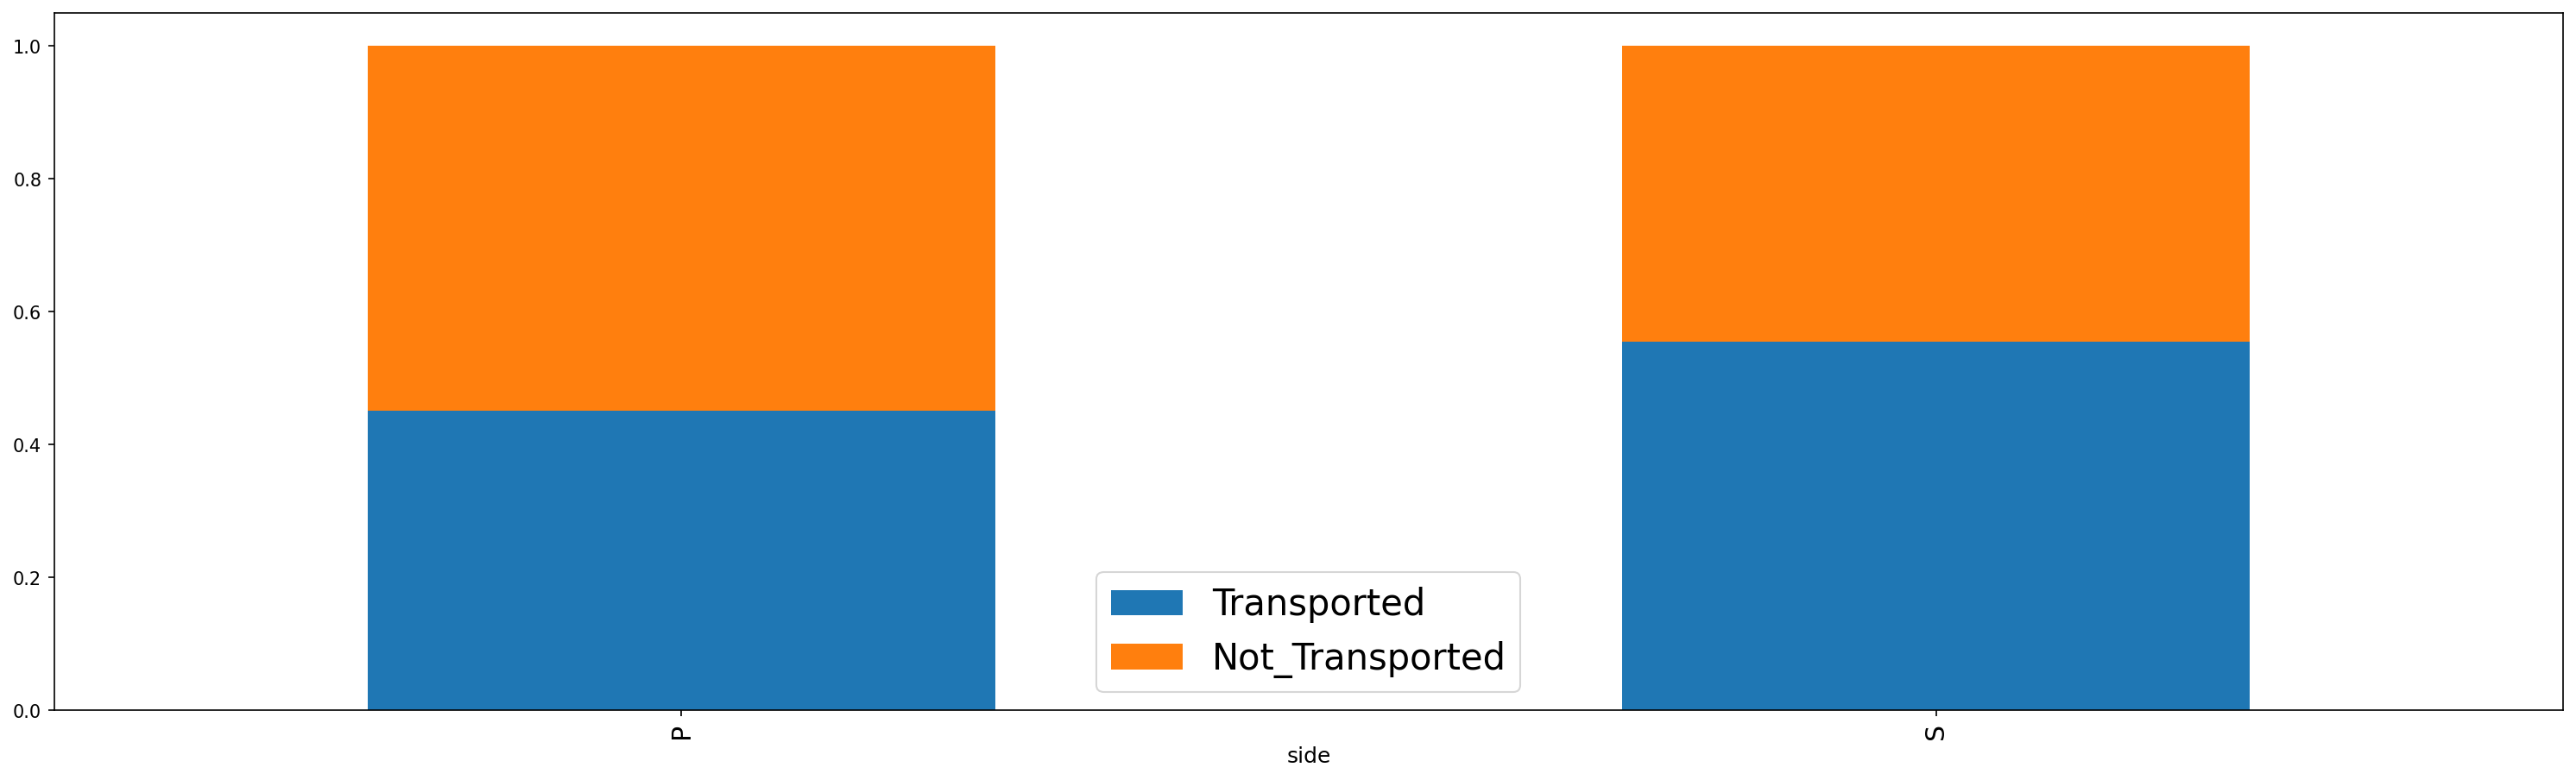

In [25]:
data.groupby('side').agg('mean')[['Transported', 'Not_Transported']].plot(kind='bar', figsize=(25, 7), stacked=True);

II - Feature engineering
In the previous part, we flirted with the data and spotted some interesting correlations.

In this part, we'll see how to process and transform these variables in such a way the data becomes manageable by a machine learning algorithm.

We'll also create, or "engineer" additional features that will be useful in building the model.

We'll see along the way how to process text variables like the passenger names and integrate this information in our model.

We will break our code in separate functions for more clarity.

But first, let's define a print function that asserts whether or not a feature has been processed.

In [26]:
def status(feature):
    print('Processing', feature, ': ok')

Loading the data
One trick when starting a machine learning problem is to append the training set to the test set together.

We'll engineer new features using the train set to prevent information leakage. Then we'll add these variables to the test set.

Let's load the train and test sets and append them together.

In [27]:
def get_combined_data():
    # reading train data
    train = pd.read_csv('./data/train.csv')
    
    # reading test data
    test = pd.read_csv('./data/test.csv')

    # extracting and then removing the targets from the training data 
    targets = train.Transported
    train.drop(['Transported'], 1, inplace=True)
    

    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

    #we split the cabin information again
    combined[['deck', 'num', 'side']] = combined.Cabin.str.split("/", expand = True)
    
    return combined

combined = get_combined_data()

Let's have a look at the shape :

In [28]:
print(combined.shape)

(12970, 15)


train and test sets are combined.

You may notice that the total number of rows (12970) is the exact summation of the number of rows in the train set and the test set.

In [29]:
combined.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


Let's see how many values in each column are missing:

In [30]:
	
combined.isna().sum()

HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
deck            299
num             299
side            299
dtype: int64

In relation to the whole dataset the missing values are not much but we still try to fill them up.

Perfect. The missing ages have been replaced.
Let's see what else is missing:

In [31]:
print('Missing values:')
print('HomePlanet: ' + str(combined.HomePlanet.isnull().sum()))
print('CryoSleep: ' + str(combined.CryoSleep.isnull().sum()))
print('Cabin: ' + str(combined.Cabin.isnull().sum()))
print('Destination: ' + str(combined.Destination.isnull().sum()))
print('VIP: ' + str(combined.VIP.isnull().sum()))
print('RoomService: ' + str(combined.RoomService.isnull().sum()))
print('FoodCourt: ' + str(combined.FoodCourt.isnull().sum()))
print('ShoppingMall: ' + str(combined.ShoppingMall.isnull().sum()))
print('Spa: ' + str(combined.Spa.isnull().sum()))
print('VRDeck: ' + str(combined.VRDeck.isnull().sum()))


Missing values:
HomePlanet: 288
CryoSleep: 310
Cabin: 299
Destination: 274
VIP: 296
RoomService: 263
FoodCourt: 289
ShoppingMall: 306
Spa: 284
VRDeck: 268




Every important column has missing values. So we try to fill them up.

#Merker: Hier code für Name table aus Titanic einfügen ggfs. defprocess_names



Processing Fare
Let's imputed the missing Spending value by the average fare computed on the train set

In [32]:
def process_roomservice():
    global combined
    # there's one missing fare value - replacing it with the mean.
    #combined.RoomService.fillna(combined.iloc[:8693].RoomService.mean(), inplace=True)
    combined.RoomService.fillna(combined.RoomService.mean(), inplace=True)
    status('RoomService')
    return combined

In [33]:
def process_foodcourt():
    global combined
    # there's one missing fare value - replacing it with the mean.
    #combined.FoodCourt.fillna(combined.iloc[:8693].FoodCourt.mean(), inplace=True)
    combined.FoodCourt.fillna(combined.FoodCourt.mean(), inplace=True)
    status('FoodCourt')
    return combined

In [34]:
def process_shoppingmall():
    global combined
    # there's one missing fare value - replacing it with the mean.
    #combined.ShoppingMall.fillna(combined.iloc[:8693].ShoppingMall.mean(), inplace=True)
    combined.ShoppingMall.fillna(combined.ShoppingMall.mean(), inplace=True)
    status('Spa')
    return combined

In [35]:
def process_spa():
    global combined
    # there's one missing fare value - replacing it with the mean.
    #combined.Spa.fillna(combined.iloc[:8693].Spa.mean(), inplace=True)
    combined.Spa.fillna(combined.Spa.mean(), inplace=True)
    status('Spa')
    return combined

In [36]:
def process_vrdeck():
    global combined
    # there's one missing fare value - replacing it with the mean.
    #combined.VRDeck.fillna(combined.iloc[:8693].VRDeck.mean(), inplace=True)
    combined.VRDeck.fillna(combined.VRDeck.mean(), inplace=True)
    status('VRDeck')
    return combined

This function simply replaces one missing spending value by the mean.

In [37]:
combined = process_roomservice()
combined = process_foodcourt()
combined = process_shoppingmall()
combined = process_spa()
combined = process_vrdeck()

Processing RoomService : ok
Processing FoodCourt : ok
Processing Spa : ok
Processing Spa : ok
Processing VRDeck : ok


Processing HomePlanet

In [38]:
def process_homeplanet():
    global combined
    # missing homeplanet values - filling them with the most frequent one in the train  set(S)
    combined.HomePlanet.fillna('Earth', inplace=True)
    # dummy encoding 
    #later: homeplanet_dummies = pd.get_dummies(combined['HomePlanet'], prefix='HomePlanet')
    #combined = pd.concat([combined, homeplanet_dummies], axis=1)
    #combined.drop('HomePlanet', axis=1, inplace=True)
    status('HomePlanet')
    return combined


This functions replaces the missing values of HomePlanet with the most frequent HomePlanet value.

In [39]:
combined = process_homeplanet()
combined['HomePlanet'] = combined['HomePlanet'].astype("string")
combined.head()

Processing HomePlanet : ok


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


In [40]:
print(combined['HomePlanet'].unique())

<StringArray>
['Europa', 'Earth', 'Mars']
Length: 3, dtype: string


As you can see :

there is no longer a name HomePlanet.
new variables (HomePlanet_X) appeared. These features are binary.

Processing VIP

As the overall number of VIP passengers is very small we simply replace the missing values by 'False'.

In [41]:
def process_vip():
    global combined
    # missing homeplanet values - filling them with the most frequent one in the train  set(S)
    combined.VIP.fillna(False, inplace=True)
    status('VIP')
    return combined

combined = process_vip()

Processing VIP : ok


In [42]:
combined.isna().sum()

HomePlanet        0
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            294
deck            299
num             299
side            299
dtype: int64

In [43]:
print(combined['VIP'].unique())

[False  True]


Processing CryoSleep

In [44]:
#print(combined.iloc[8693:].CryoSleep.isnull().sum())
print(combined.CryoSleep.isnull().sum())

310


For the missing cryo sleep values we analyse the most common value by group of HomeDestination, Destination and VIP status.

In [45]:


grouped_cryosleep = combined[['HomePlanet','VIP','Destination','CryoSleep']].copy()

grouped_cryosleep = grouped_cryosleep.groupby(['HomePlanet','VIP','Destination','CryoSleep']).agg(CryoSleepCount=('CryoSleep', 'count'))

grouped_cryosleep.groupby(['HomePlanet','VIP','Destination'], sort=False)['CryoSleepCount'].max()

idx = grouped_cryosleep.groupby(['HomePlanet','VIP','Destination'])['CryoSleepCount'].transform(max) == grouped_cryosleep['CryoSleepCount']

grouped_cryosleep = grouped_cryosleep[idx]
grouped_cryosleep = grouped_cryosleep.reset_index()
grouped_cryosleep.head()

,HomePlanet,VIP,Destination,CryoSleep,CryoSleepCount
0,Earth,False,55 Cancri e,False,688
1,Earth,False,PSO J318.5-22,True,544
2,Earth,False,TRAPPIST-1e,False,3479
3,Earth,True,55 Cancri e,False,1
4,Earth,True,55 Cancri e,True,1


We fill the empty cryo sleep values base on this analysis:

In [46]:
def fill_cryosleep(row):
    condition = (
        (grouped_cryosleep['HomePlanet'] == row['HomePlanet']) & 
        (grouped_cryosleep['VIP'] == row['VIP']) & 
        (grouped_cryosleep['Destination'] == row['Destination'])
    )
    arr = grouped_cryosleep[condition]['CryoSleep'].values[:]
    s = set()
    for i in arr:
        s.add(i)
    return bool(s)

def process_cryosleep():
    global combined
    # a function that fills the missing values of the Age variable
    combined['CryoSleep'] = combined.apply(lambda row: fill_cryosleep(row) if np.isnan(row['CryoSleep']) else row['CryoSleep'], axis=1)
    status('CryoSleep')
    return combined

combined = process_cryosleep()

#fill empty cells with false
combined.CryoSleep.fillna(False, inplace=True)

Processing CryoSleep : ok


In [47]:
combined.to_csv('file_name.csv')

In [48]:
print('Missing CryoSleep values: ' + str(combined.CryoSleep.isnull().sum()))

Missing CryoSleep values: 0


All CryoSleep values have been set. Finally we check if the values are correct:

In [49]:
print(combined['CryoSleep'].unique())

[False  True]


Processing Destination

In [50]:
#print(combined.iloc[8693:].Destination.isnull().sum())
print(combined.Destination.isnull().sum())

274


For the missing destination values we analyse the most common value by group of HomePlanet, CryoSleep status and VIP status.

In [51]:
combined.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


In [52]:

grouped_destination = combined[['HomePlanet','VIP','CryoSleep','Destination']].copy()


grouped_destination = grouped_destination.groupby(['HomePlanet','VIP','CryoSleep','Destination']).agg(DestinationCount=('Destination', 'count'))

grouped_destination.groupby(['HomePlanet','VIP','CryoSleep'], sort=False)['DestinationCount'].max()

idx = grouped_destination.groupby(['HomePlanet','VIP','CryoSleep'])['DestinationCount'].transform(max) == grouped_destination['DestinationCount']

grouped_destination = grouped_destination[idx]
grouped_destination = grouped_destination.reset_index()
grouped_destination

,HomePlanet,VIP,CryoSleep,Destination,DestinationCount
0,Earth,False,False,TRAPPIST-1e,3479
1,Earth,False,True,TRAPPIST-1e,1395
2,Earth,True,False,TRAPPIST-1e,4
3,Earth,True,True,55 Cancri e,1
4,Europa,False,False,TRAPPIST-1e,951
5,Europa,False,True,TRAPPIST-1e,708
6,Europa,True,False,55 Cancri e,67
7,Europa,True,True,55 Cancri e,16
8,Mars,False,False,TRAPPIST-1e,1258
9,Mars,False,True,TRAPPIST-1e,917


We fill the empty cryo sleep values base on this analysis:

In [53]:
def fill_destination(row):
    condition = (
        (grouped_destination['HomePlanet'] == row['HomePlanet']) & 
        (grouped_destination['VIP'] == row['VIP']) & 
        (grouped_destination['CryoSleep'] == row['CryoSleep'])
    ) 
    arr = grouped_destination[condition]['Destination'].values[:]
    s = set()
    for i in arr:
        s.add(i)
    s = str(s)
    s = s.replace("{'", '')
    s = s.replace("'}", '')    
    return s

def process_destination():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Destination'] = combined.apply(lambda row: fill_destination(row) if pd.isnull(row['Destination']) else row['Destination'], axis=1)
    status('Destination')
    return combined

combined = process_destination()

Processing Destination : ok


In [54]:
print('Missing Destination values: ' + str(combined.Destination.isnull().sum()))

Missing Destination values: 0


In [55]:
print(combined['Destination'].unique())

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']


All Destination values have been set and are valid.
What is next?

In [56]:
combined.isna().sum()

HomePlanet        0
CryoSleep         0
Cabin           299
Destination       0
Age             270
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            294
deck            299
num             299
side            299
dtype: int64

Processing the ages

There are 270 age values missing.

To avoid data leakage from the test set, we fill in missing ages in the train using the train set and we fill in ages in the test set using values calculated from the train set as well.

Number of missing ages in train set

In [57]:
#print(combined.iloc[:8693].Age.isnull().sum())
print(combined.Age.isnull().sum())

270


Number of missing ages in test set

In [58]:
#print(combined.iloc[8693:].Age.isnull().sum())

#rouped_train = combined.iloc[:8693].groupby(['CryoSleep','VIP','HomePlanet', 'Destination'])
grouped_train = combined.groupby(['CryoSleep','VIP','HomePlanet', 'Destination'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['CryoSleep', 'VIP', 'HomePlanet', 'Destination', 'Age']]

grouped_median_train#.head()

,CryoSleep,VIP,HomePlanet,Destination,Age
0,False,False,Earth,55 Cancri e,23.0
1,False,False,Earth,PSO J318.5-22,25.0
2,False,False,Earth,TRAPPIST-1e,24.0
3,False,False,Europa,55 Cancri e,34.0
4,False,False,Europa,TRAPPIST-1e,33.0
5,False,False,Mars,55 Cancri e,24.0
6,False,False,Mars,PSO J318.5-22,34.5
7,False,False,Mars,TRAPPIST-1e,28.0
8,False,True,Earth,55 Cancri e,29.0
9,False,True,Earth,TRAPPIST-1e,41.5


This dataframe will help us impute missing age values based on different criteria.

Look at the median age column and see how this value can be different based on the other parameters.

Let's create a function that fills in the missing age in combined based on these different attributes.

In [59]:
print(combined['Age'].unique())

[39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]


In [60]:
def fill_age(row):
    condition = (
        (grouped_median_train['CryoSleep'] == row['CryoSleep']) & 
        (grouped_median_train['VIP'] == row['VIP']) & 
        (grouped_median_train['HomePlanet'] == row['HomePlanet']) &
        (grouped_median_train['Destination'] == row['Destination'])
    ) 
    arr = grouped_median_train[condition]['Age']#.values[:]
    s = set()
    for i in arr:
        s.add(i)
    s = str(s)
    s = s.replace("{", '')
    s = s.replace("}", '')
    return float(s)
    
def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('Age')
    return combined

combined = process_age()

Processing Age : ok


In [61]:
print('Missing values Age: ' + str(combined.Age.isnull().sum()))

Missing values Age: 0


In [62]:
print(combined['Age'].unique())

[39.  24.  58.  33.  16.  44.  26.  28.  35.  14.  34.  45.  32.  48.
 31.  27.   0.   1.  49.  29.  10.   7.  21.  62.  15.  43.  47.   2.
 20.  23.  30.  17.  55.   4.  19.  56.  25.  38.  36.  22.  18.  42.
 37.  13.   8.  40.   3.  54.   9.   6.  64.  67.  61.  50.  41.  57.
 11.  52.  51.  46.  60.  63.  59.   5.  79.  68.  74.  12.  53.  65.
 71.  75.  70.  76.  78.  73.  66.  69.  72.  77.  32.5 34.5]


All age values are set and converter to float.

Process Cabin

In [63]:
combined.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


As we already have separated the cabin information we can delete the cabin and num column as we won't use it. Same goes for the 'name' column.

In [64]:
combined = combined.drop(columns=['Cabin', 'num', 'Name'])

In [65]:
combined.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S


In [66]:
combined.isna().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
deck            299
side            299
dtype: int64

Process side

In [67]:
print(combined['deck'].unique())

['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']


We create a table to find the most frequent deck use by other values:

In [68]:
grouped_deck = combined[['HomePlanet','VIP','CryoSleep','Destination', 'deck']].copy()


grouped_deck = grouped_deck.groupby(['HomePlanet','VIP','CryoSleep','Destination', 'deck']).agg(deckCount=('deck', 'count'))

grouped_deck.groupby(['HomePlanet','VIP','CryoSleep', 'Destination'], sort=False)['deckCount'].max()

idx = grouped_deck.groupby(['HomePlanet','VIP','CryoSleep', 'Destination'])['deckCount'].transform(max) == grouped_deck['deckCount']

grouped_deck = grouped_deck[idx]
grouped_deck = grouped_deck.reset_index()
grouped_deck

,HomePlanet,VIP,CryoSleep,Destination,deck,deckCount
0,Earth,False,False,55 Cancri e,F,367
1,Earth,False,False,PSO J318.5-22,F,307
2,Earth,False,False,TRAPPIST-1e,F,1750
3,Earth,False,True,55 Cancri e,G,303
4,Earth,False,True,PSO J318.5-22,G,532
5,Earth,False,True,TRAPPIST-1e,G,1270
6,Earth,True,False,55 Cancri e,D,1
7,Earth,True,False,TRAPPIST-1e,F,3
8,Earth,True,True,55 Cancri e,D,1
9,Europa,False,False,55 Cancri e,C,203


We fill the empty cryo sleep values base on this analysis:

In [69]:
def fill_deck(row):
    condition = (
        (grouped_deck['HomePlanet'] == row['HomePlanet']) & 
        (grouped_deck['VIP'] == row['VIP']) & 
        (grouped_deck['CryoSleep'] == row['CryoSleep']) &
        (grouped_deck['Destination'] == row['Destination'])
    ) 
    arr = grouped_deck[condition]['deck'].values[:]
    s = set()
    for i in arr:
        s.add(i)
    s = str(s)
    s = s.replace("{'", '')
    s = s.replace("'}", '')    
    return s

def process_deck():
    global combined
    # a function that fills the missing values of the Age variable
    combined['deck'] = combined.apply(lambda row: fill_deck(row) if pd.isnull(row['deck']) else row['deck'], axis=1)
    status('deck')
    return combined

combined = process_deck()

Processing deck : ok


In [70]:
print('Missing deck values: ' + str(combined.deck.isnull().sum()))

Missing deck values: 0


In [71]:
print(combined['deck'].unique())

['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']


That looks great. Now we do the same with the side an then we should have filled all important empty cells.

Process side

In [72]:
print(combined['side'].unique())

['P' 'S' nan]


We create a table to find the most frequent deck use by other values:

In [73]:
grouped_side= combined[['HomePlanet','VIP','CryoSleep','Destination', 'side']].copy()


grouped_side = grouped_side.groupby(['HomePlanet','VIP','CryoSleep','Destination', 'side']).agg(sideCount=('side', 'count'))

grouped_side.groupby(['HomePlanet','VIP','CryoSleep', 'Destination'], sort=False)['sideCount'].max()

idx = grouped_side.groupby(['HomePlanet','VIP','CryoSleep', 'Destination'])['sideCount'].transform(max) == grouped_side['sideCount']

grouped_side = grouped_side[idx]
grouped_side = grouped_side.reset_index()
grouped_side

,HomePlanet,VIP,CryoSleep,Destination,side,sideCount
0,Earth,False,False,55 Cancri e,S,341
1,Earth,False,False,PSO J318.5-22,S,259
2,Earth,False,False,TRAPPIST-1e,P,1789
3,Earth,False,True,55 Cancri e,S,187
4,Earth,False,True,PSO J318.5-22,P,295
5,Earth,False,True,TRAPPIST-1e,P,691
6,Earth,True,False,55 Cancri e,S,1
7,Earth,True,False,TRAPPIST-1e,S,3
8,Earth,True,True,55 Cancri e,S,1
9,Europa,False,False,55 Cancri e,S,285


We fill the empty cryo sleep values base on this analysis:

In [74]:
def fill_side(row):
    condition = (
        (grouped_side['HomePlanet'] == row['HomePlanet']) & 
        (grouped_side['VIP'] == row['VIP']) & 
        (grouped_side['CryoSleep'] == row['CryoSleep']) &
        (grouped_side['Destination'] == row['Destination'])
    ) 
    arr = grouped_side[condition]['side'].values[:]
    s = set()
    for i in arr:
        s.add(i)
    s = str(s)
    s = s.replace("{'", '')
    s = s.replace("'}", '')    
    return s

def process_side():
    global combined
    # a function that fills the missing values of the Age variable
    combined['side'] = combined.apply(lambda row: fill_side(row) if pd.isnull(row['side']) else row['side'], axis=1)
    status('side')
    return combined

combined = process_side()

Processing side : ok


In [75]:
print('Missing side values: ' + str(combined.side.isnull().sum()))

Missing side values: 0


In [76]:
print(combined['side'].unique())

['P' 'S']


A final check for missing values:

In [77]:
combined.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
deck            0
side            0
dtype: int64

All right, all done.

Processing data format

Let's have a look at our table again:

In [78]:
combined.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S


We only want columns with int, float or boolean values so we use dummy encoding to transform the others in binary columns and then delete the originals

In [79]:
def process_bin():
    global combined
    # dummy encoding 
    #HomePlanet
    homeplanet_dummies = pd.get_dummies(combined['HomePlanet'], prefix='HomePlanet')
    combined = pd.concat([combined, homeplanet_dummies], axis=1)
    combined.drop('HomePlanet', axis=1, inplace=True)

    #Destination
    destination_dummies = pd.get_dummies(combined['Destination'], prefix='Destination')
    combined = pd.concat([combined, destination_dummies], axis=1)
    combined.drop('Destination', axis=1, inplace=True)

    #deck
    deck_dummies = pd.get_dummies(combined['deck'], prefix='deck')
    combined = pd.concat([combined, deck_dummies], axis=1)
    combined.drop('deck', axis=1, inplace=True)     

    #side
    side_dummies = pd.get_dummies(combined['side'], prefix='side')
    combined = pd.concat([combined, side_dummies], axis=1)
    combined.drop('side', axis=1, inplace=True) 
    return combined

combined = process_bin()    

In [80]:
combined.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


All columns look good. Now we move on to modelling

III - Modeling

In this part, we use our knowledge of the passengers based on the features we created and then build a statistical model. You can think of this model as a box that crunches the information of any new passenger and decides whether or not he is transported.

There is a wide variety of models to use, from logistic regression to decision trees and more sophisticated ones such as random forests and gradient boosted trees.

We'll be using Random Forests. Random Froests has proven a great efficiency in Kaggle competitions.

For more details about why ensemble methods perform well, you can refer to these posts:

http://mlwave.com/kaggle-ensembling-guide/
http://www.overkillanalytics.net/more-is-always-better-the-power-of-simple-ensembles/
Back to our problem, we now have to:

Break the combined dataset in train set and test set.
Use the train set to build a predictive model.
Evaluate the model using the train set.
Test the model using the test set and generate and output file for the submission.
Keep in mind that we'll have to reiterate on 2. and 3. until an acceptable evaluation score is achieved.

Let's start by importing the useful libraries.

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

To evaluate our model we'll be using a 5-fold cross validation with the accuracy since it's the metric that the competition uses in the leaderboard.

To do that, we'll define a small scoring function.

In [85]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

Recovering the train set and the test set from the combined dataset is an easy task.

In [86]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('./data/train.csv', usecols=['Transported'])['Transported'].values
    train = combined.iloc[:8693]
    test = combined.iloc[8693:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

Feature selection

We've come up to 24 features so far. This number is quite large.

When feature engineering is done, we usually tend to decrease the dimensionality by selecting the "right" number of features that capture the essential.

In fact, feature selection comes with many benefits:

It decreases redundancy among the data
It speeds up the training process
It reduces overfitting
Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.

In [87]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

Let's have a look at the importance of each feature.

<AxesSubplot: ylabel='feature'>

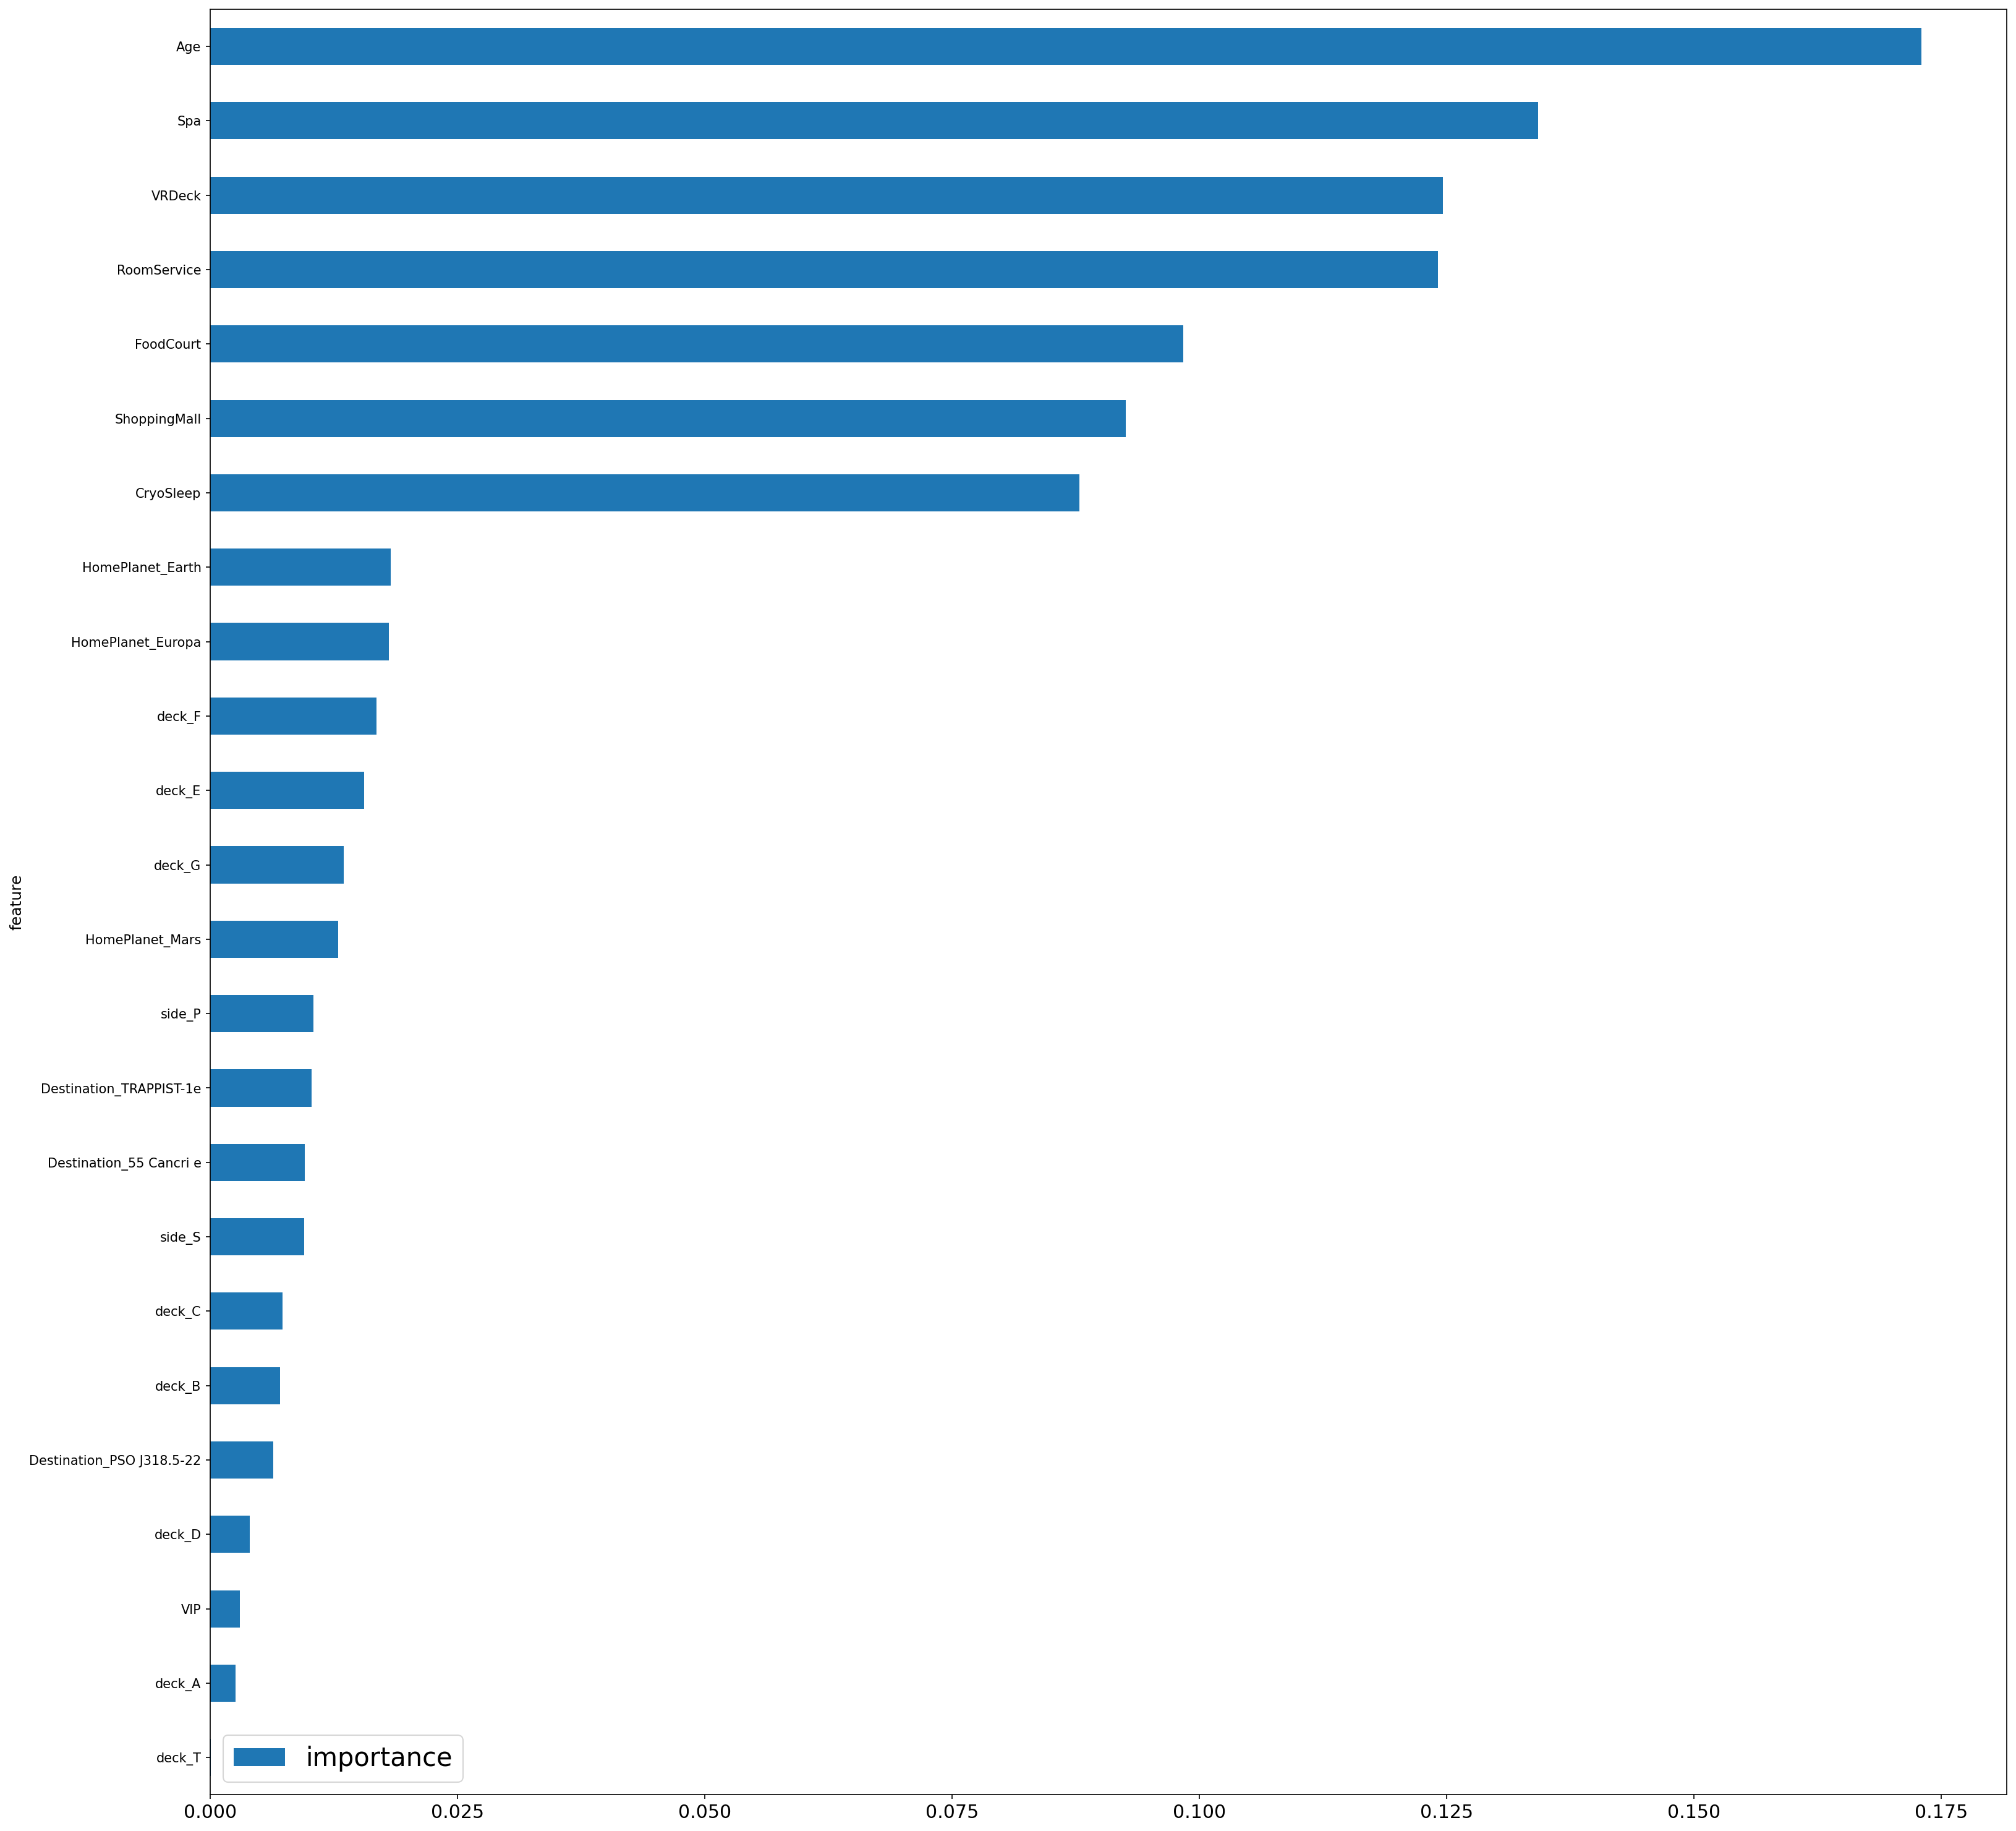

In [88]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

As you may notice, there is a great importance linked to Age, Spending and cryo sleep.

Let's now transform our train set and test set in a more compact datasets.

In [89]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)


test_reduced = model.transform(test)
print(test_reduced.shape)

(8693, 7)
(4277, 7)


Yay! Now we're down to a lot less features.

We'll see if we'll use the reduced or the full version of the train set.

Let's try different base models

In [90]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.7789035932585623
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.7881075919589252
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.788108319861619
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.7945505233951234
****


Hyperparameters tuning

As mentioned in the beginning of the Modeling part, we will be using a Random Forest model. It may not be the best model for this task but we'll show how to tune. This work can be applied to different models.

Random Forest are quite handy. They do however come with some parameters to tweak in order to get an optimal model for the prediction task.

To learn more about Random Forests, you can refer to this link :

Additionally, we'll use the full train set.

In [91]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Now that the model is built by scanning several combinations of the hyperparameters, we can generate an output file to submit on Kaggle.

In [95]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Transported'] = output
df_output['Transported'] = df_output['Transported'].astype(bool)
df_output[['PassengerId','Transported']].to_csv('./predictions/gridsearch_rf.csv', index=False)

BONUS: Blending different models

I haven't personally uploaded a submission based on model blending but here's how you could do it

In [94]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Transported']
predictions_df['Transported'] = predictions_df['Transported'].astype(bool)

predictions_df.to_csv('./predictions/blending_base_models.csv', index=False)